# Cirrhosis Outcomes Prediction – Problem Definition

## Objective
We want to build a machine learning model to predict the outcome of cirrhosis patients.

- Input: Clinical features (demographics, lab tests, clinical signs) for each patient.
- Output: Probabilities for each of three classes:
  - C  : Patient was alive at N_Days (censored).
  - CL : Patient was alive at N_Days because of liver transplant.
  - D  : Patient was deceased at N_Days.

## Data
- train.csv: 15,000 patient records, 20 columns (including `Status` as target).
- test.csv: 10,000 patient records, 19 columns (no `Status`).
- sample_submission.csv: Example submission format (id, Status_C, Status_CL, Status_D).

## Metric
Submissions are evaluated using multi-class logarithmic loss (log-loss).
For each patient, we need to predict:
- P(Status = C),
- P(Status = CL),
- P(Status = D).

The closer the predicted probabilities to the true class, the lower the log-loss.

## Constraints & Considerations
- The dataset is AI-generated but simulates real-world clinical patterns.
- Missing values are present in many lab features (Bilirubin, Cholesterol, Copper, SGOT, etc.).
- Classes may be imbalanced (we will confirm in EDA).
- We must produce calibrated probabilities, not just hard class labels.


In [1]:
import os
import pandas as pd

# 1) Paths
BASE_DIR = r"C:\liver"
INPUT_DIR = os.path.join(BASE_DIR, "input")

train_path = os.path.join(BASE_DIR, "train.csv")   # النسخة الأساسية
test_path = os.path.join(BASE_DIR, "test.csv")
sample_sub_path = os.path.join(BASE_DIR, "sample_submission.csv")

print("BASE_DIR :", BASE_DIR)
print("Train exists:", os.path.isfile(train_path))
print("Test exists :", os.path.isfile(test_path))
print("Sample sub exists:", os.path.isfile(sample_sub_path))

# 2) Load data
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sample_sub = pd.read_csv(sample_sub_path)

print("\nShapes:")
print("Train:", train.shape)
print("Test :", test.shape)
print("Sample submission:", sample_sub.shape)

print("\nTrain columns:")
print(train.columns.tolist())

print("\nTarget (Status) distribution:")
print(train["Status"].value_counts(dropna=False))
print("\nTarget (Status) distribution (%):")
print(train["Status"].value_counts(normalize=True) * 100)


BASE_DIR : C:\liver
Train exists: True
Test exists : True
Sample sub exists: True

Shapes:
Train: (15000, 20)
Test : (10000, 19)
Sample submission: (10000, 4)

Train columns:
['id', 'N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Status']

Target (Status) distribution:
Status
C     10188
D      4457
CL      355
Name: count, dtype: int64

Target (Status) distribution (%):
Status
C     67.920000
D     29.713333
CL     2.366667
Name: proportion, dtype: float64


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno  # لو مش موجود يعمل ImportError، سأتجاوز ذلك لاحقاً

%matplotlib inline

# Paths
BASE_DIR = r"C:\liver"
train_path = os.path.join(BASE_DIR, "train.csv")
test_path = os.path.join(BASE_DIR, "test.csv")

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print("Train shape:", train.shape)
print("Test shape :", test.shape)


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno  # لو مش موجود يعمل ImportError، سأتجاوز ذلك لاحقاً

%matplotlib inline

# Paths
BASE_DIR = r"C:\liver"
train_path = os.path.join(BASE_DIR, "train.csv")
test_path = os.path.join(BASE_DIR, "test.csv")

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print("Train shape:", train.shape)
print("Test shape :", test.shape)


Train shape: (15000, 20)
Test shape : (10000, 19)


In [2]:
# Info about columns and types
train.info()

# Numeric description
train.describe().T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15000 non-null  int64  
 1   N_Days         15000 non-null  float64
 2   Drug           8465 non-null   object 
 3   Age            15000 non-null  float64
 4   Sex            15000 non-null  object 
 5   Ascites        8468 non-null   object 
 6   Hepatomegaly   8457 non-null   object 
 7   Spiders        8454 non-null   object 
 8   Edema          15000 non-null  object 
 9   Bilirubin      15000 non-null  float64
 10  Cholesterol    6577 non-null   float64
 11  Albumin        15000 non-null  float64
 12  Copper         8352 non-null   float64
 13  Alk_Phos       8455 non-null   float64
 14  SGOT           8453 non-null   float64
 15  Tryglicerides  6536 non-null   float64
 16  Platelets      14429 non-null  float64
 17  Prothrombin    14978 non-null  float64
 18  Stage 

,count,mean,std,min,25%,50%,75%,max
id,15000.0,7499.500000,4330.271354,0.00,3749.75,7499.50,11249.25,14999.00
N_Days,15000.0,1969.946667,1363.291266,7.00,1092.00,1783.00,2615.00,28320.00
Age,15000.0,19302.694200,3670.223736,26.00,16688.00,19577.00,22347.00,34306.00
Bilirubin,15000.0,1.870407,2.764496,0.30,0.70,0.90,1.80,28.00
Cholesterol,6577.0,330.244625,233.017331,57.00,239.00,280.00,360.00,12258.80
Albumin,15000.0,3.517905,0.375463,1.96,3.29,3.58,3.77,4.64
Copper,8352.0,75.713218,75.273820,1.00,31.00,52.00,91.00,588.00
Alk_Phos,8455.0,1646.678912,1843.084589,289.00,720.00,1070.00,1653.00,16802.40
SGOT,8453.0,107.223005,134.329424,6.80,71.00,97.65,130.20,11552.00
Tryglicerides,6536.0,110.738472,49.122499,33.00,80.00,99.00,133.00,598.00


In [3]:
target_col = "Status"

numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
# We keep 'id' as numeric but will ignore it later as a feature
print("Numeric columns:", numeric_cols)

categorical_cols = [
    col for col in train.columns
    if col not in numeric_cols and col != target_col
]
print("Categorical columns:", categorical_cols)


Numeric columns: ['id', 'N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']
Categorical columns: ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']


Status counts:
Status
C     10188
D      4457
CL      355
Name: count, dtype: int64

Status percentages:
Status
C     67.920000
D     29.713333
CL     2.366667
Name: proportion, dtype: float64


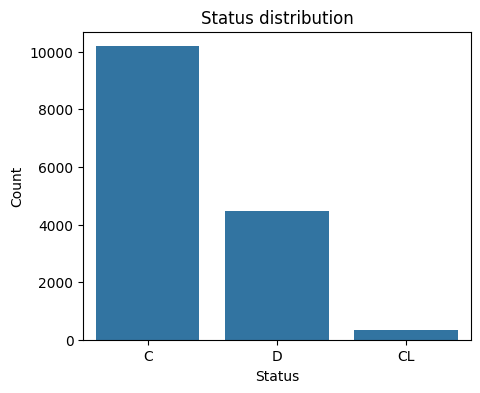

In [4]:
status_counts = train[target_col].value_counts(dropna=False)
status_pct = train[target_col].value_counts(normalize=True) * 100

print("Status counts:")
print(status_counts)
print("\nStatus percentages:")
print(status_pct)

# Plot
plt.figure(figsize=(5, 4))
sns.countplot(x=target_col, data=train, order=status_counts.index)
plt.title("Status distribution")
plt.ylabel("Count")
plt.show()


In [5]:
key_numeric = [
    "N_Days", "Age",
    "Bilirubin", "Cholesterol", "Albumin",
    "Copper", "Alk_Phos", "SGOT", "Tryglicerides",
    "Platelets", "Prothrombin", "Stage"
]

key_numeric = [c for c in key_numeric if c in train.columns]

key_numeric


['N_Days',
 'Age',
 'Bilirubin',
 'Cholesterol',
 'Albumin',
 'Copper',
 'Alk_Phos',
 'SGOT',
 'Tryglicerides',
 'Platelets',
 'Prothrombin',
 'Stage']

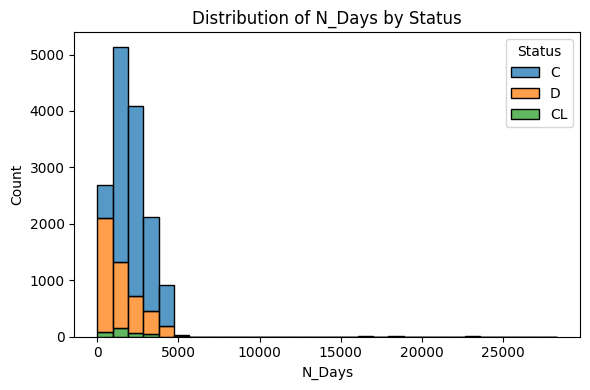

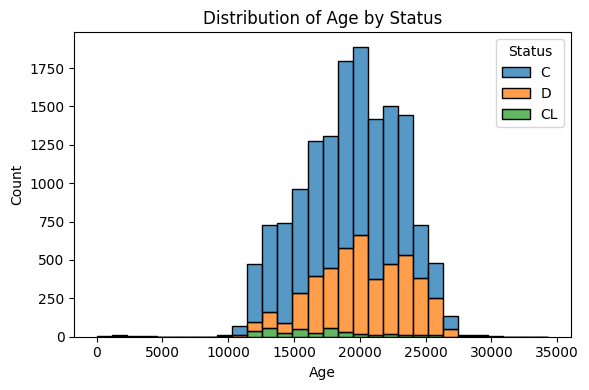

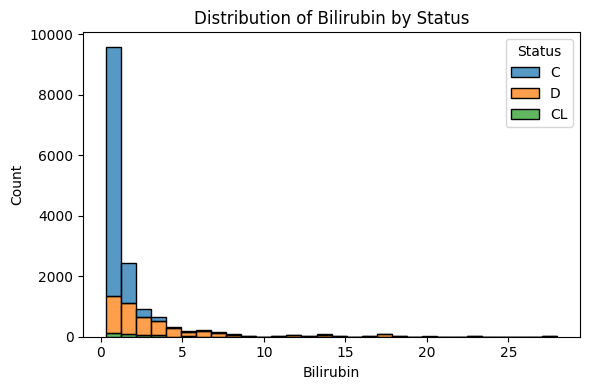

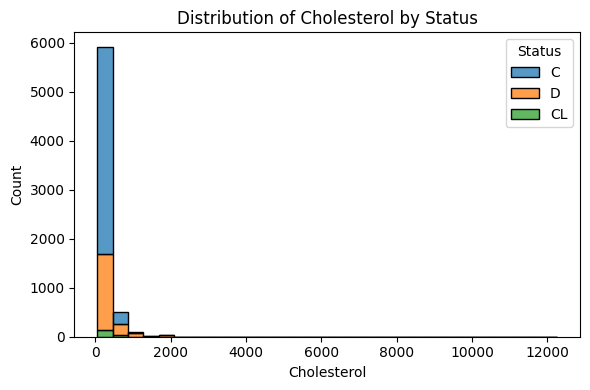

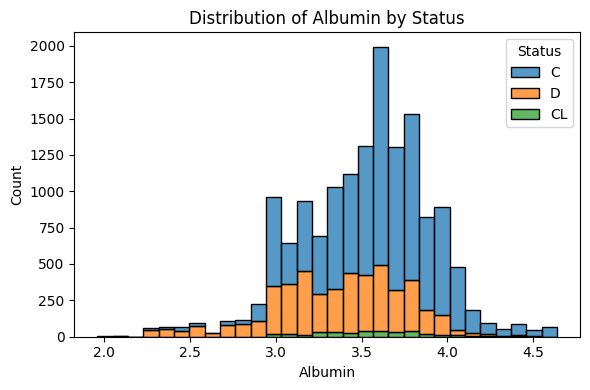

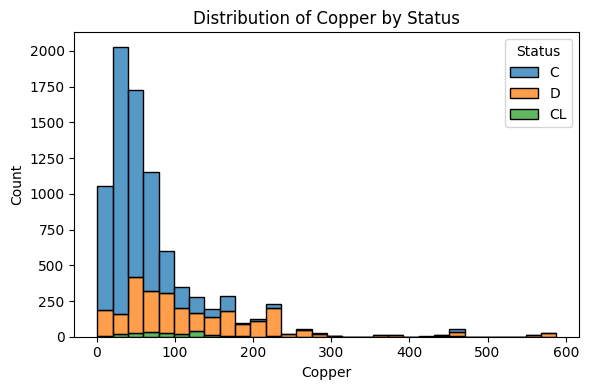

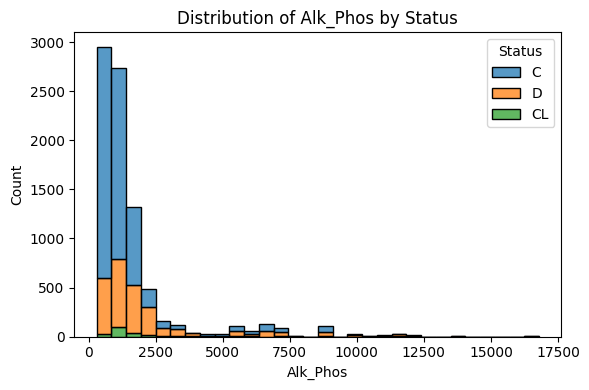

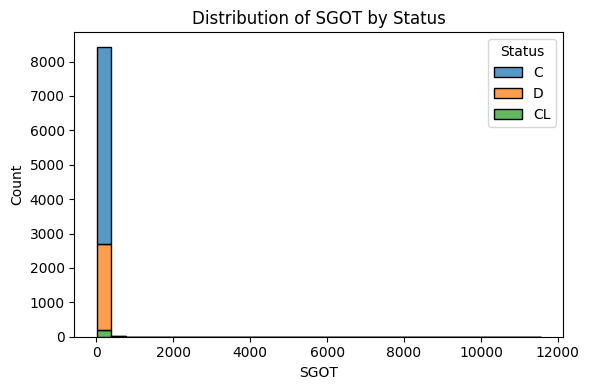

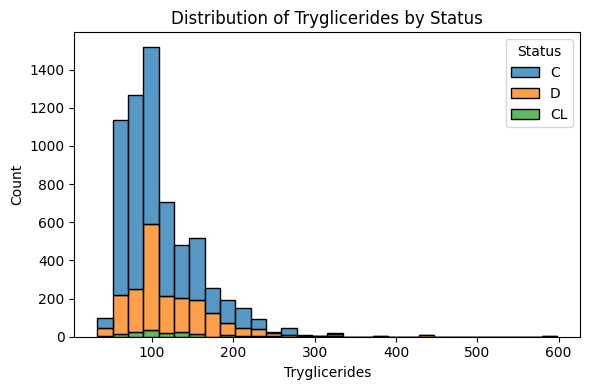

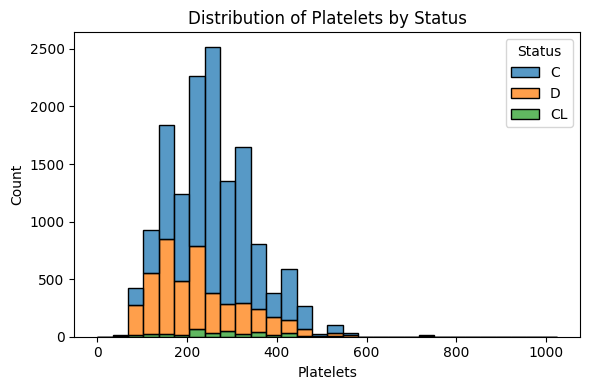

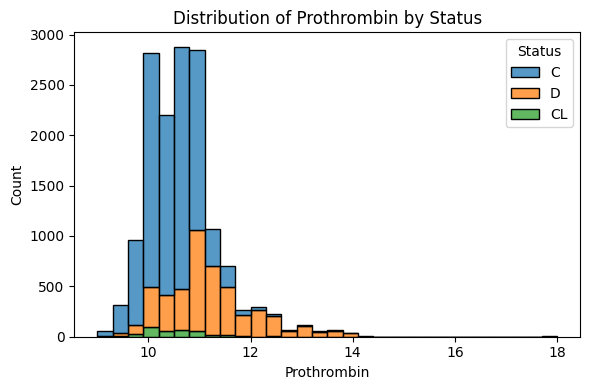

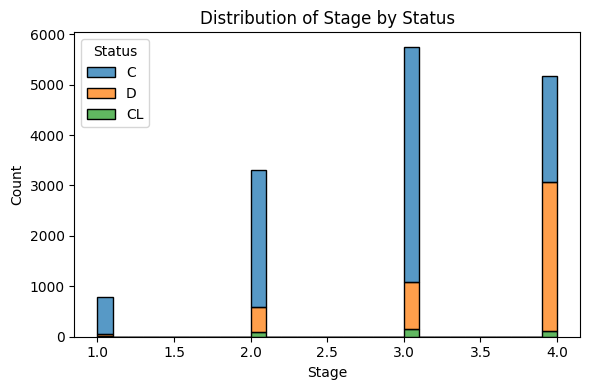

In [6]:
for col in key_numeric:
    plt.figure(figsize=(6, 4))
    sns.histplot(
        data=train,
        x=col,
        hue=target_col,
        multiple="stack",
        bins=30,
        kde=False
    )
    plt.title(f"Distribution of {col} by Status")
    plt.tight_layout()
    plt.show()


In [9]:
# Missing values count and ratio
missing_count = train.isna().sum().sort_values(ascending=False)
missing_ratio = (missing_count / len(train)).sort_values(ascending=False)

missing_df = pd.DataFrame({
    "missing_count": missing_count,
    "missing_ratio": missing_ratio
})

missing_df.head(15)


,missing_count,missing_ratio
Tryglicerides,8464,0.564267
Cholesterol,8423,0.561533
Copper,6648,0.443200
SGOT,6547,0.436467
Spiders,6546,0.436400
Alk_Phos,6545,0.436333
Hepatomegaly,6543,0.436200
Drug,6535,0.435667
Ascites,6532,0.435467
Platelets,571,0.038067


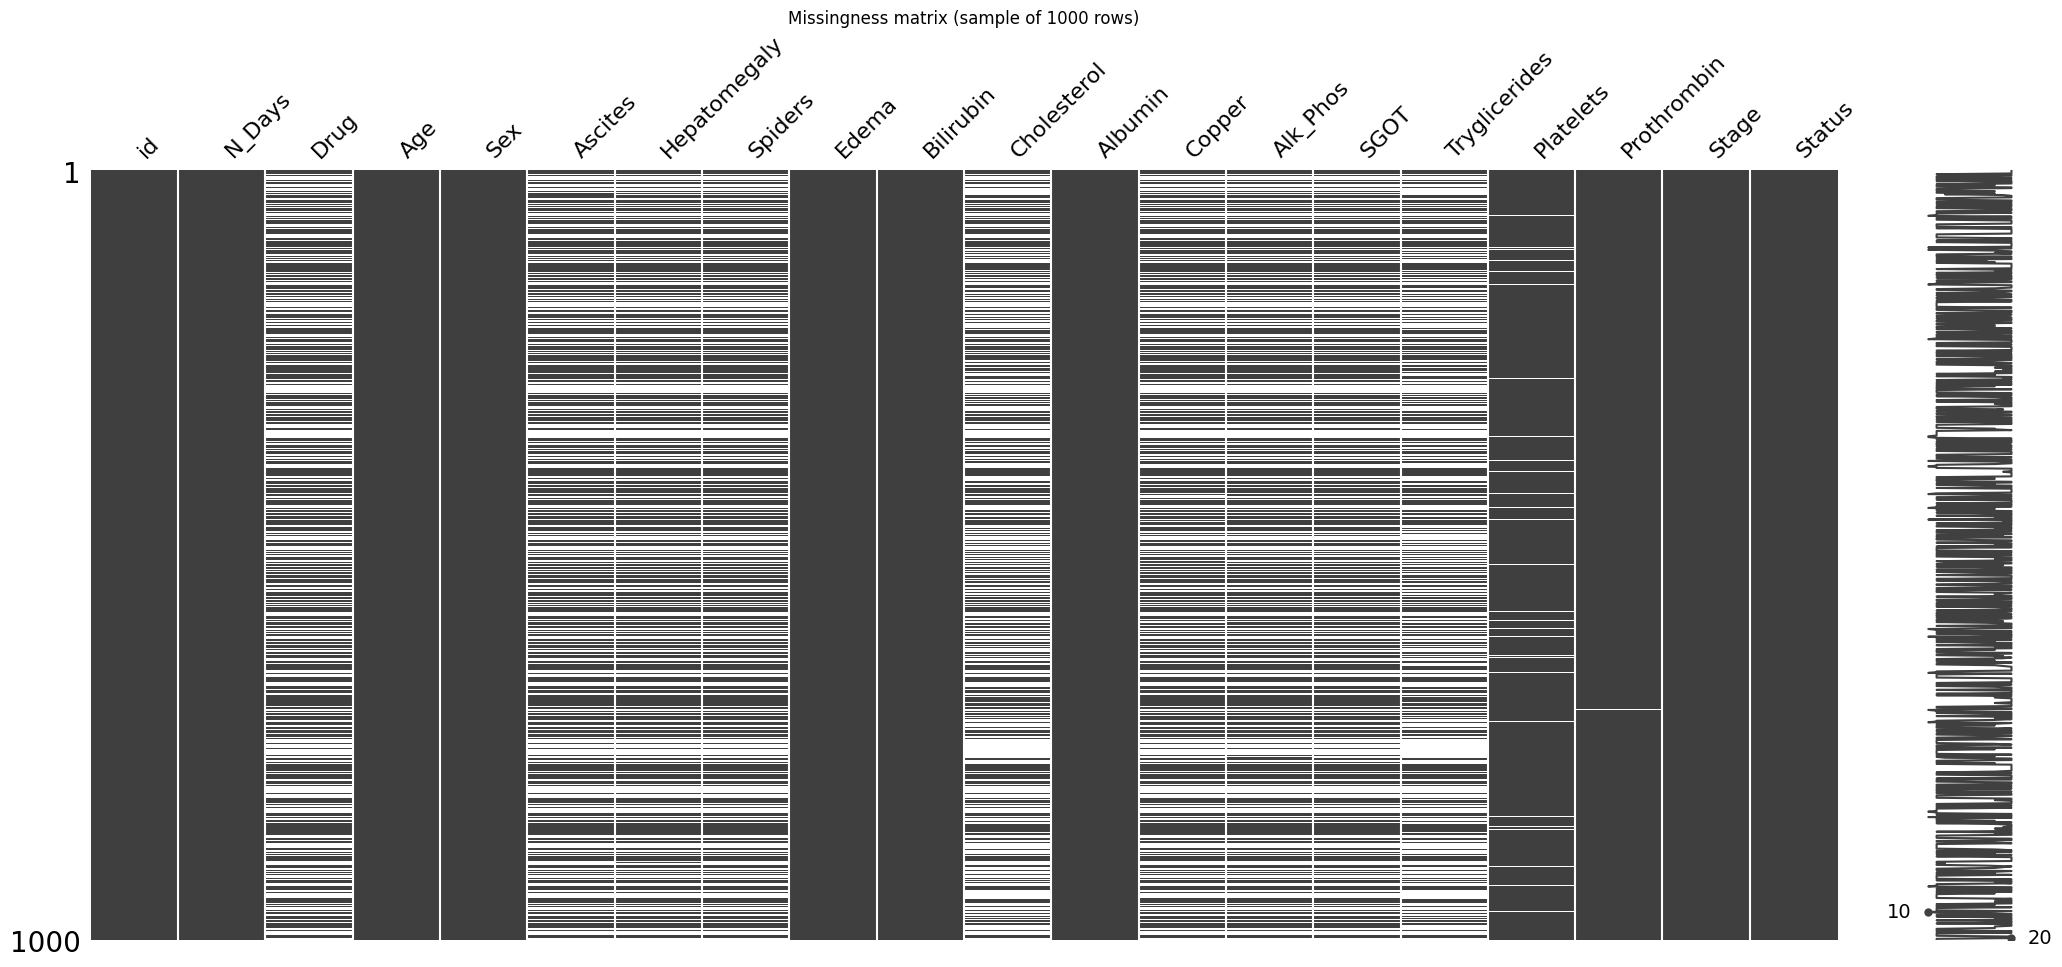

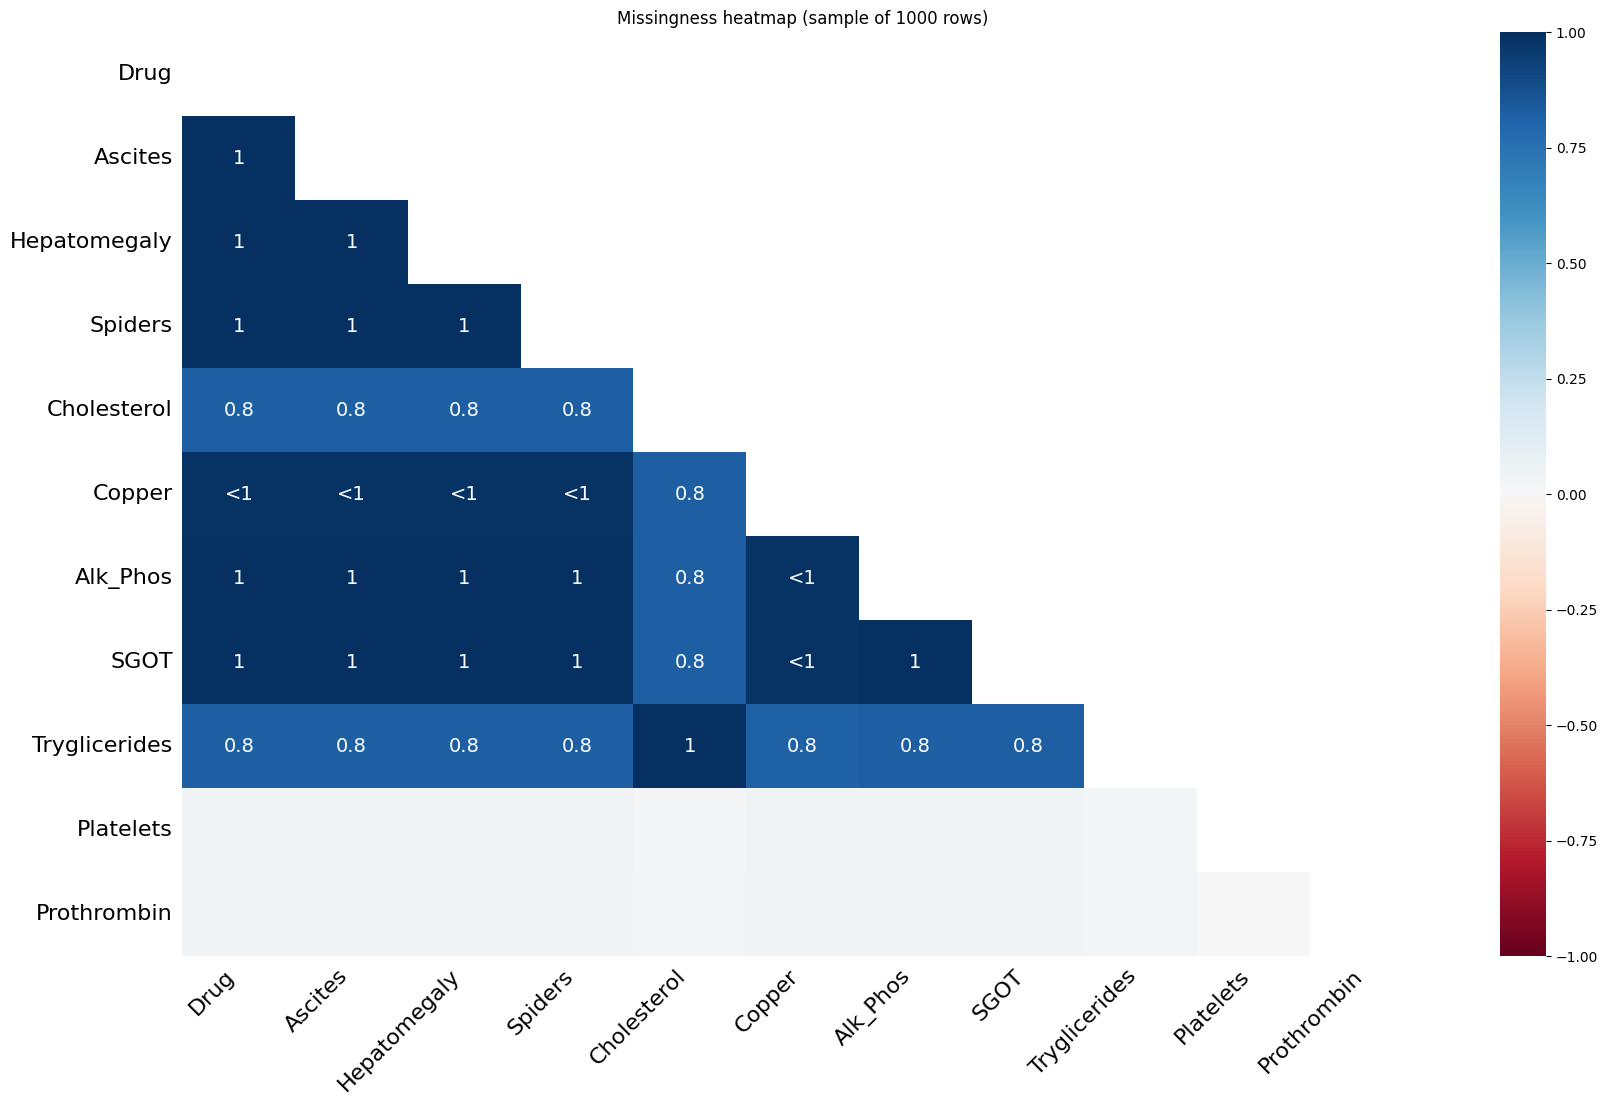

In [10]:
# Visualize missingness for a sample of rows (for readability)
sample_for_missing = train.sample(n=1000, random_state=42)

msno.matrix(sample_for_missing)
plt.title("Missingness matrix (sample of 1000 rows)")
plt.show()

msno.heatmap(sample_for_missing)
plt.title("Missingness heatmap (sample of 1000 rows)")
plt.show()


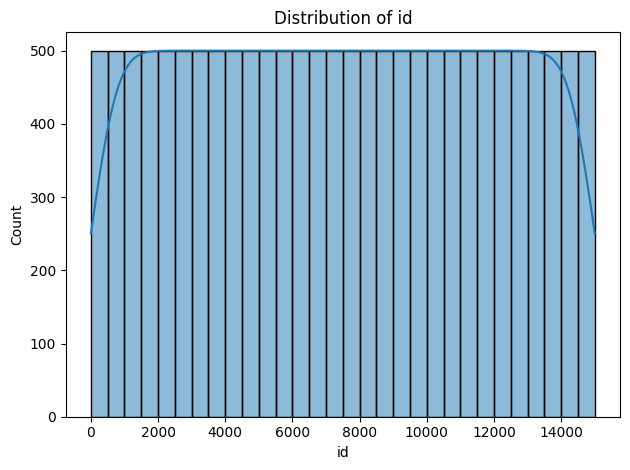

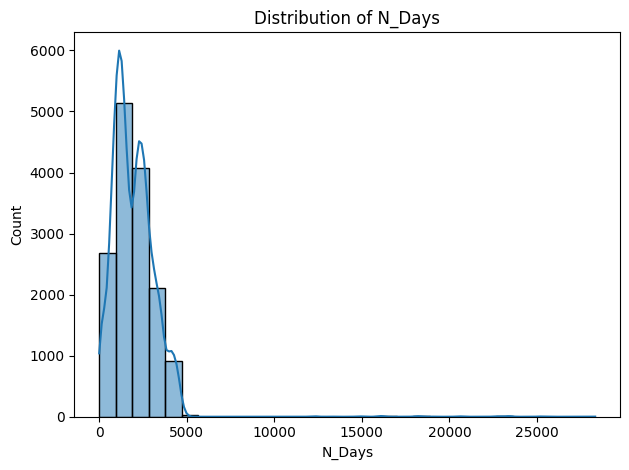

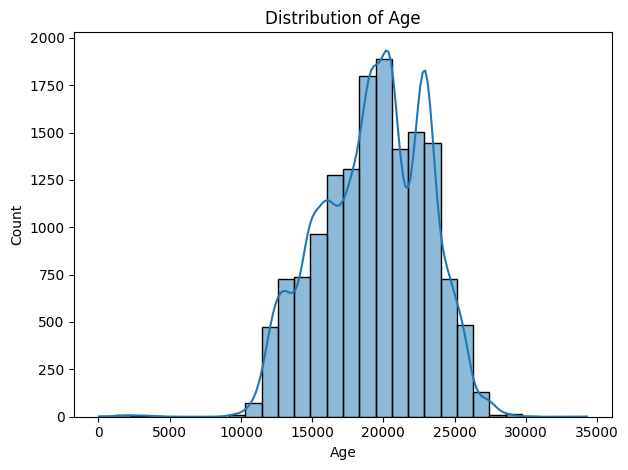

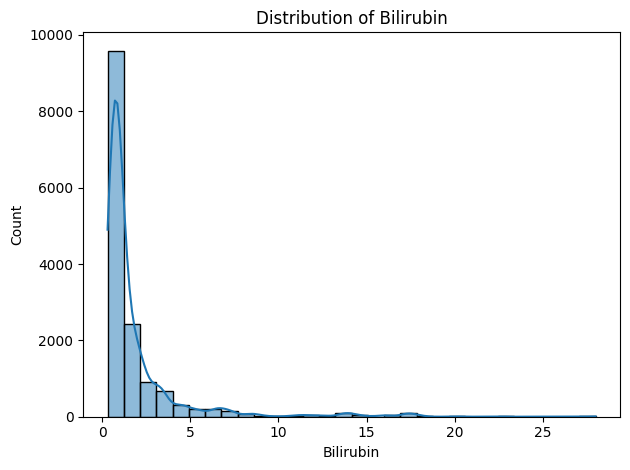

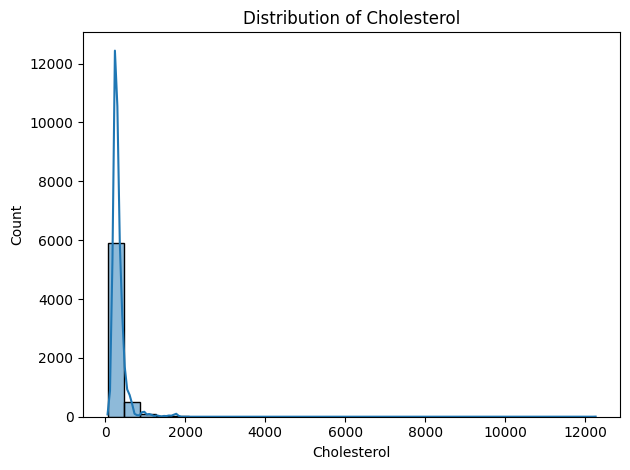

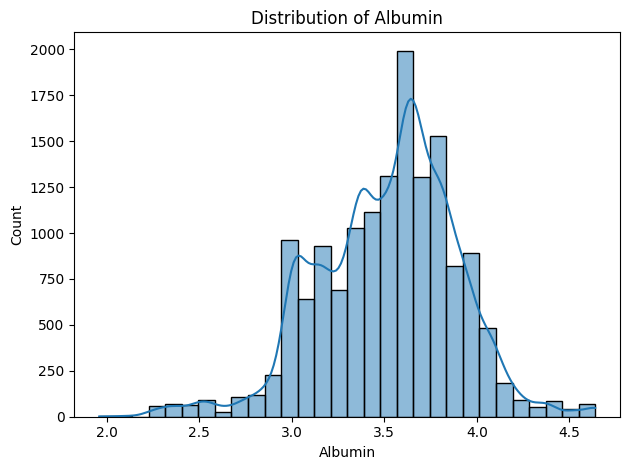

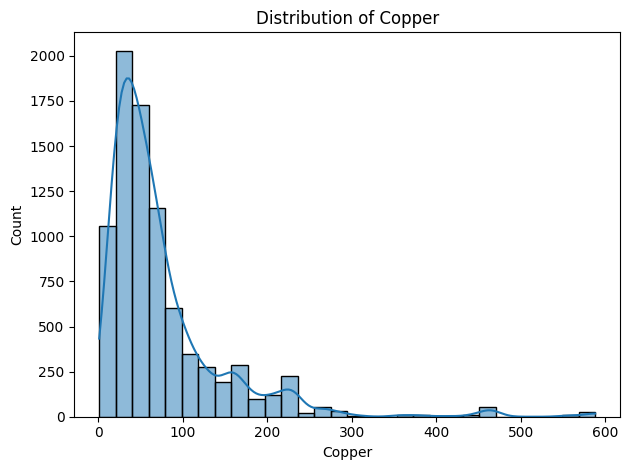

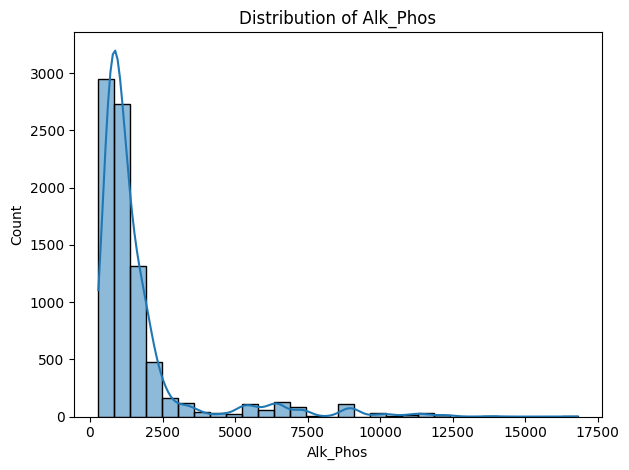

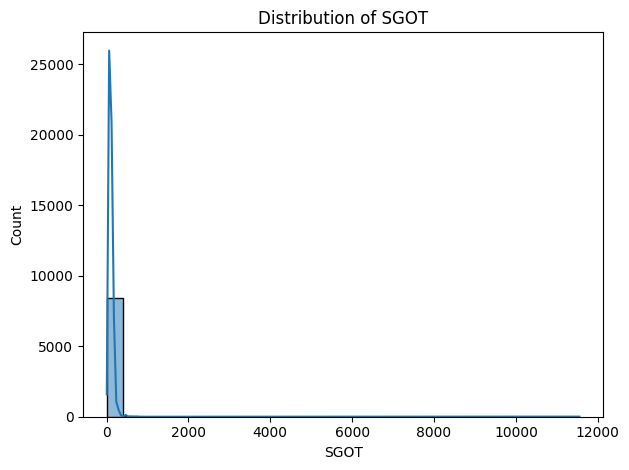

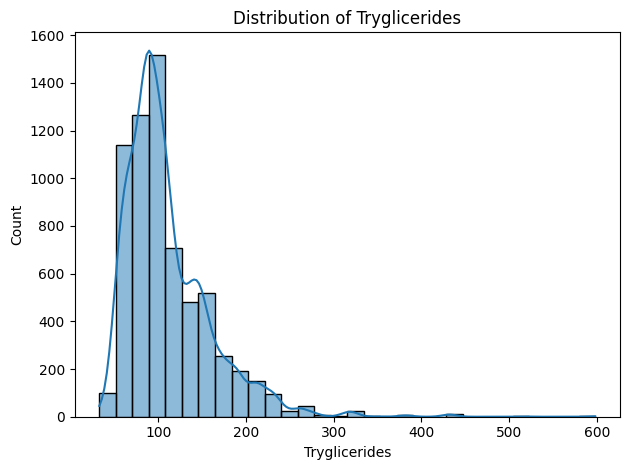

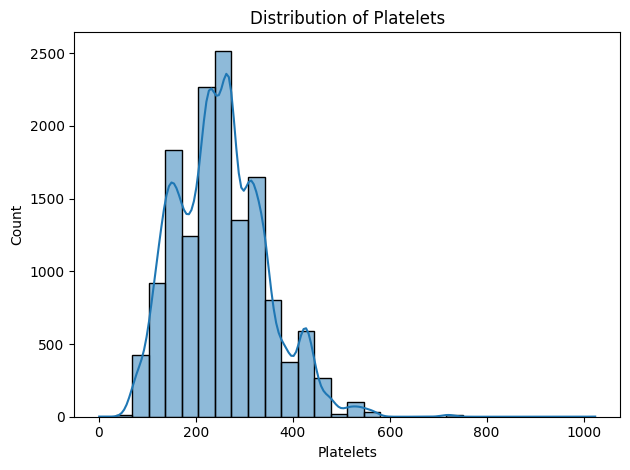

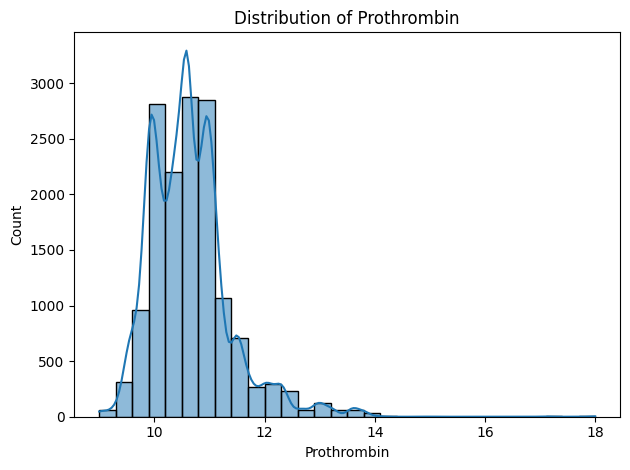

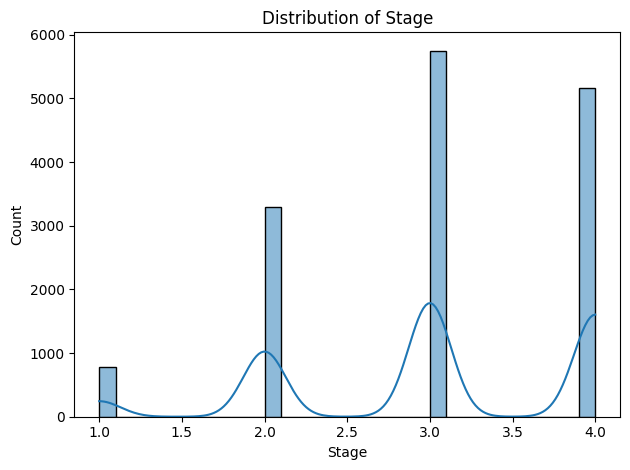

In [11]:
# Histograms for numeric features
for col in numeric_features:
    plt.figure()
    sns.histplot(train[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


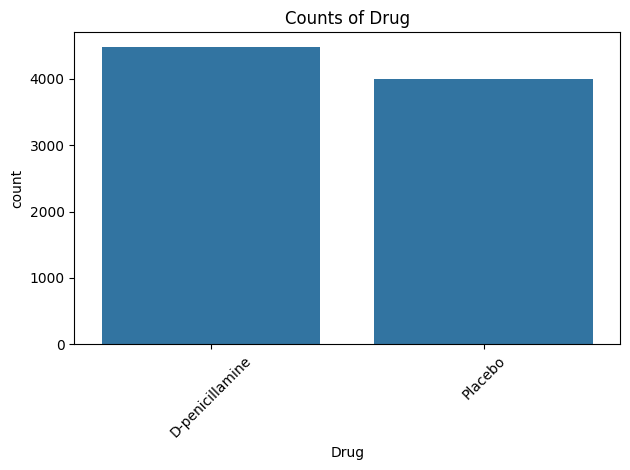

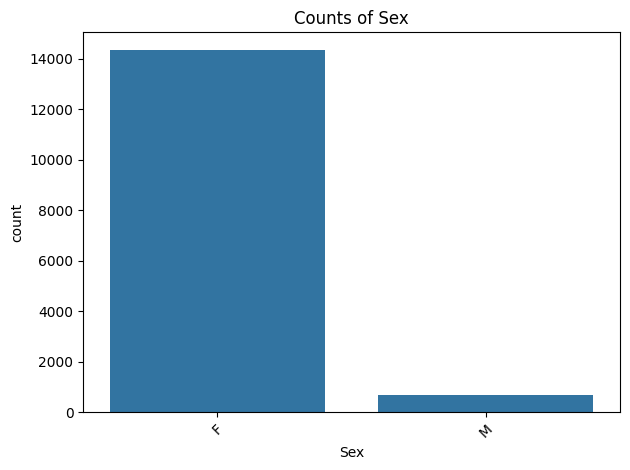

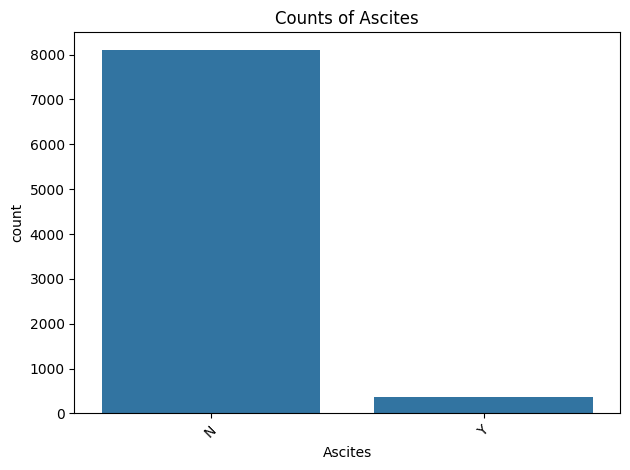

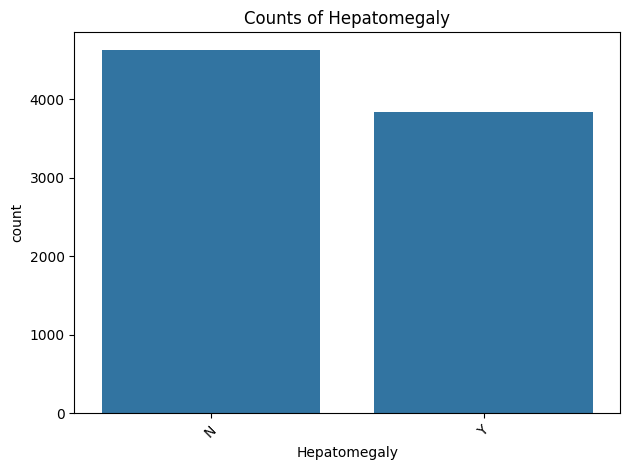

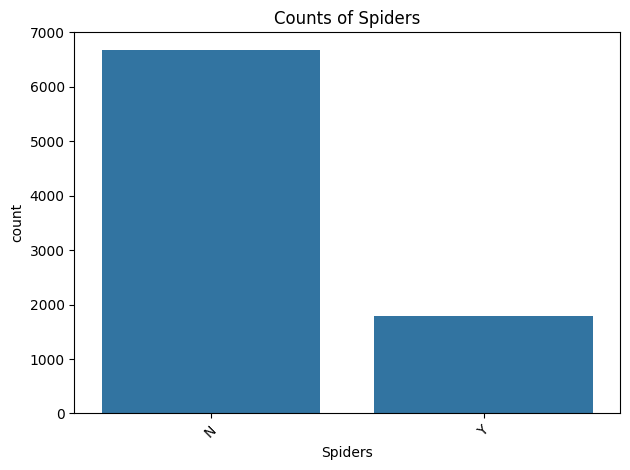

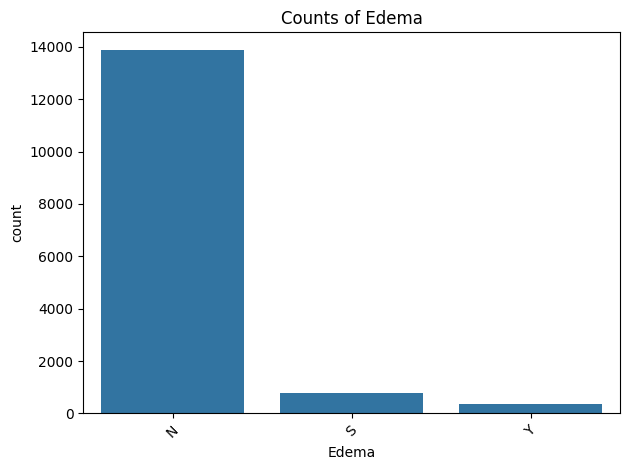

In [12]:
for col in categorical_features:
    plt.figure()
    sns.countplot(x=col, data=train)
    plt.title(f"Counts of {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


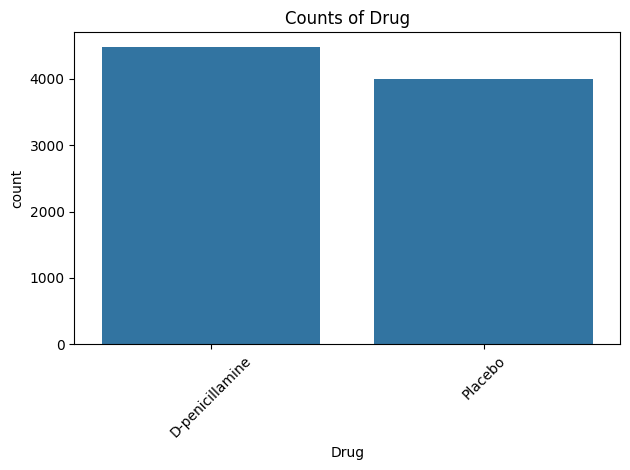

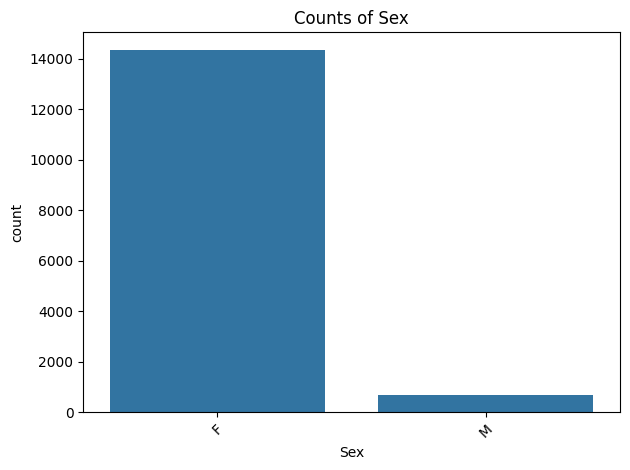

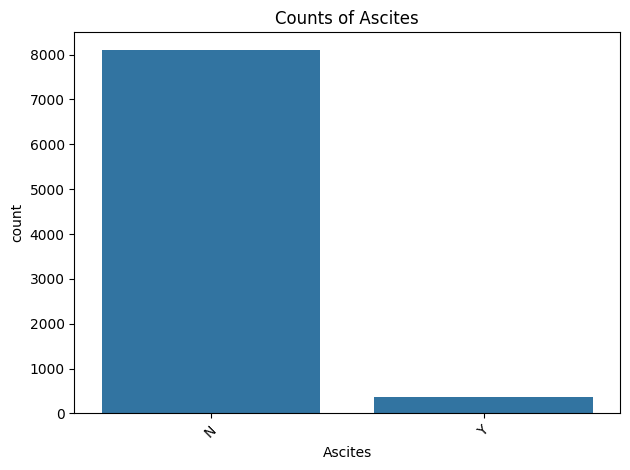

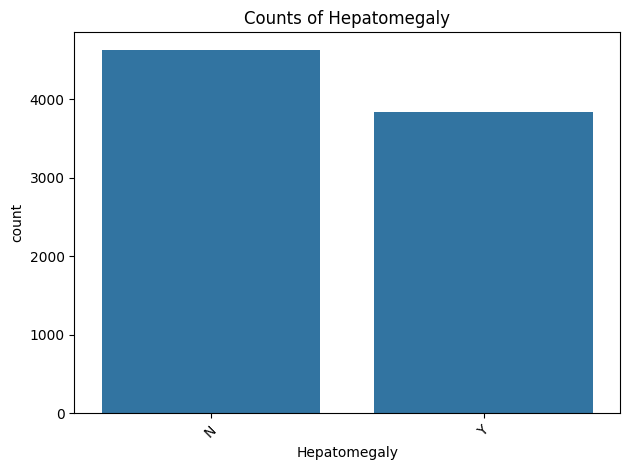

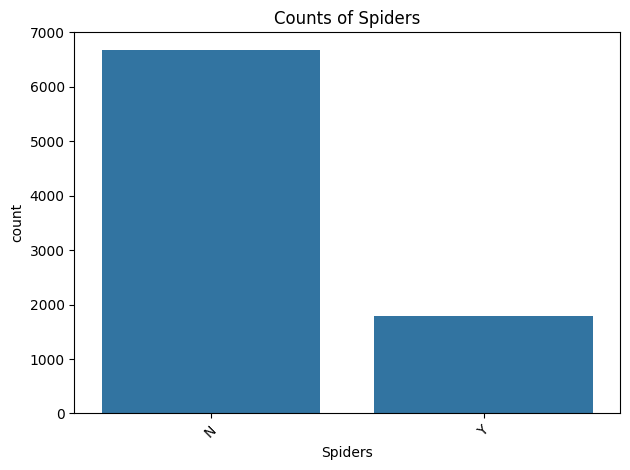

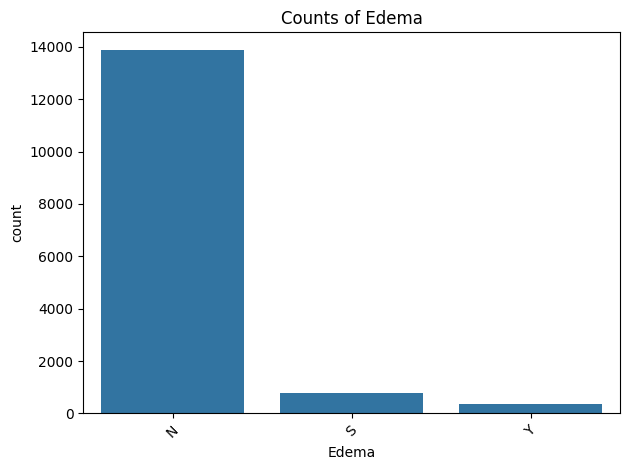

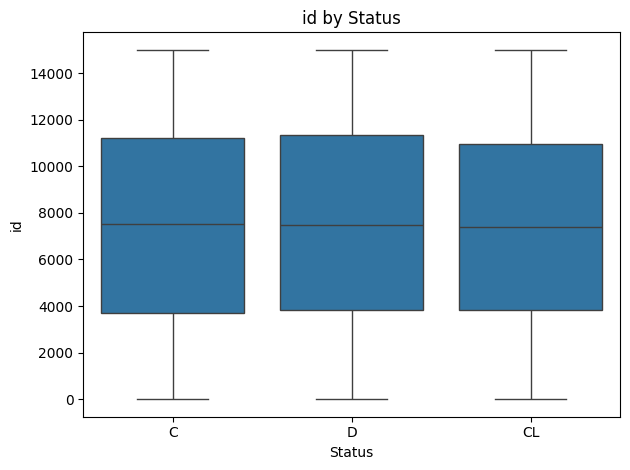

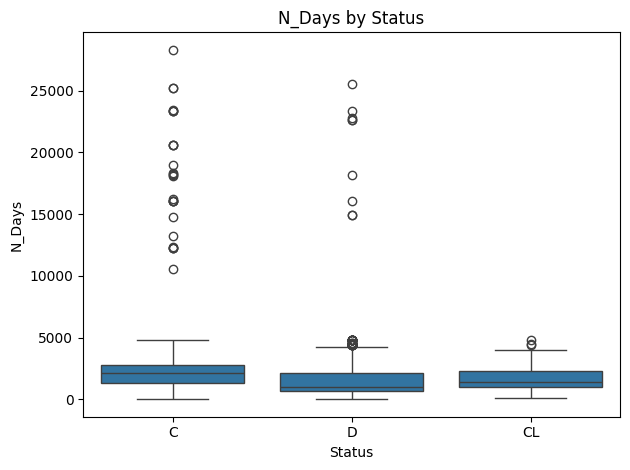

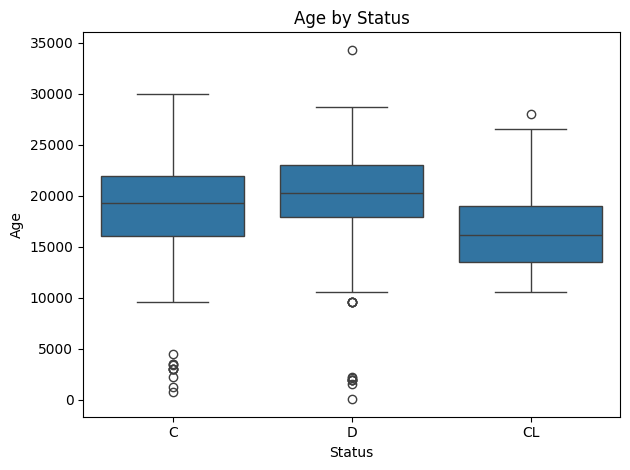

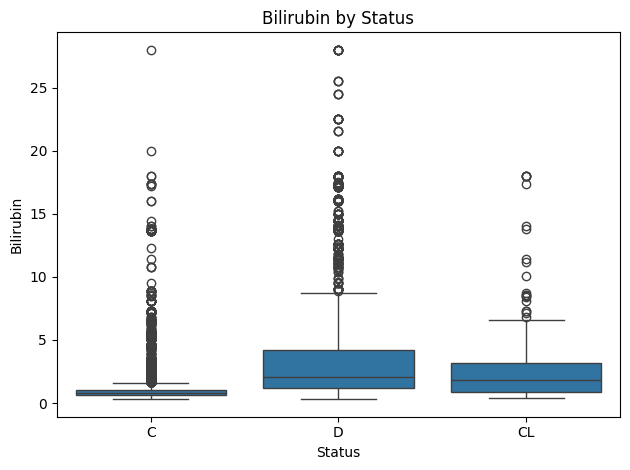

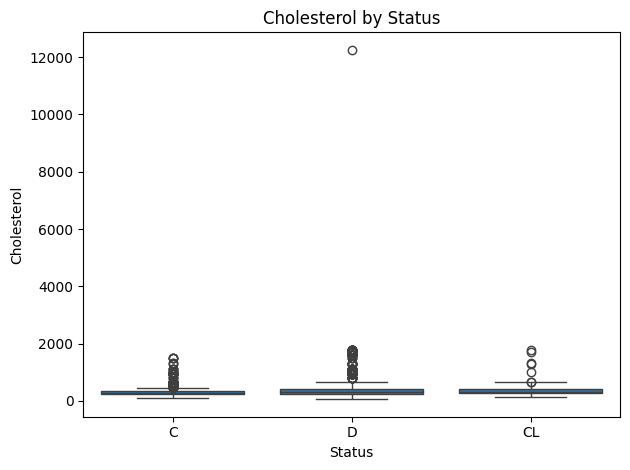

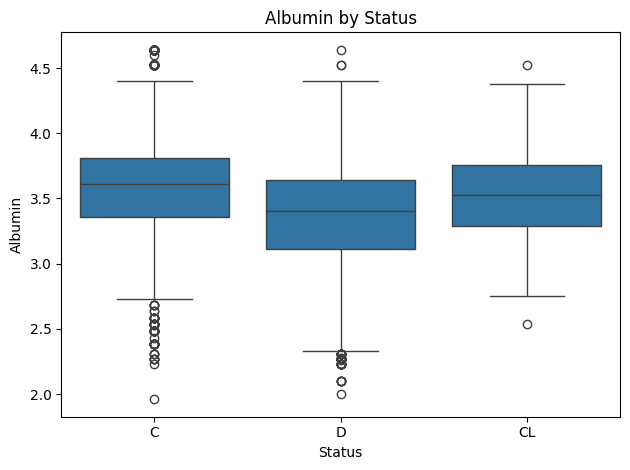

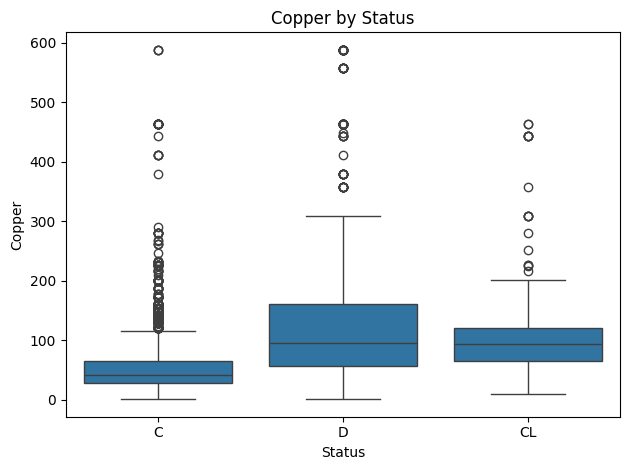

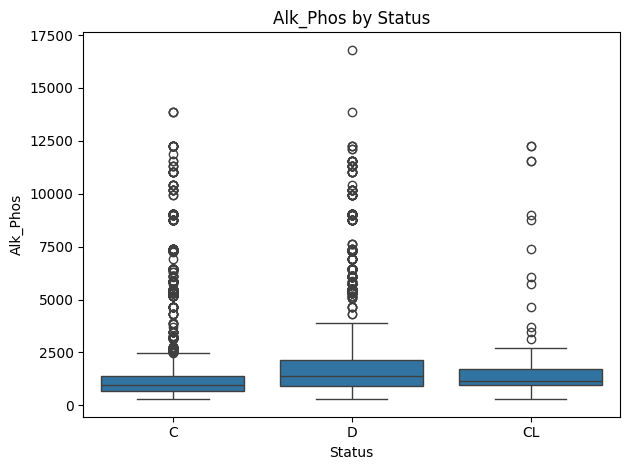

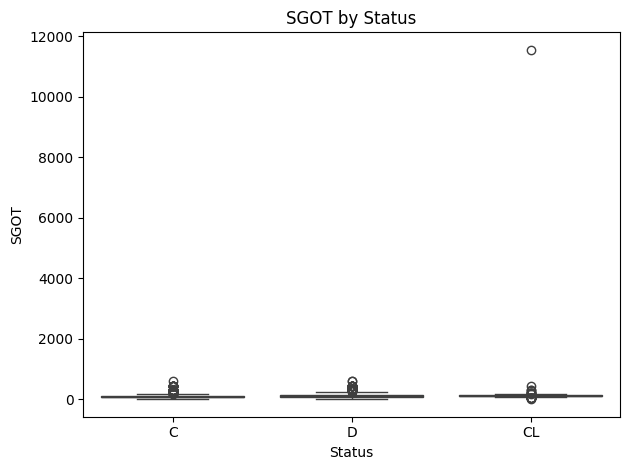

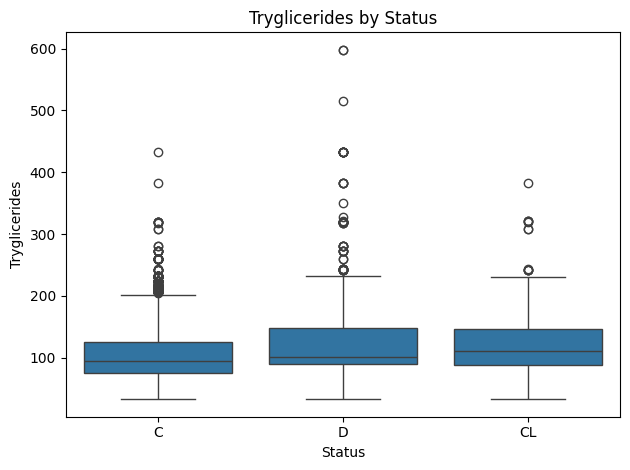

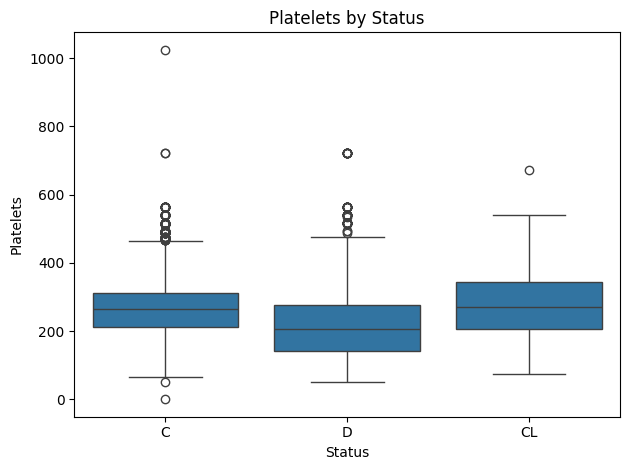

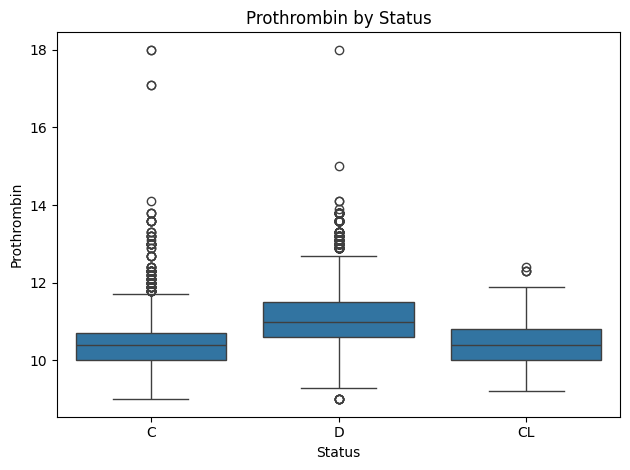

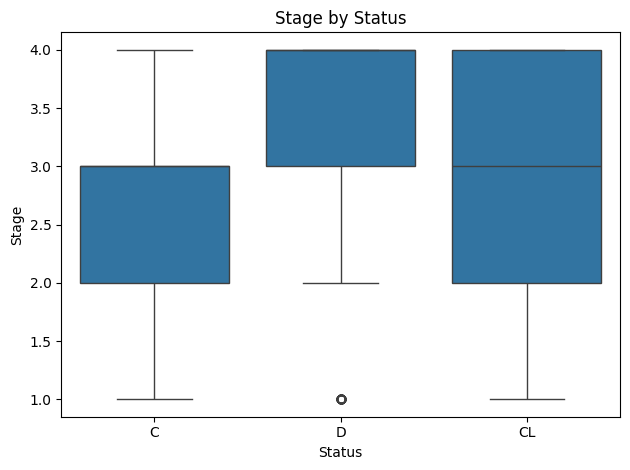

In [14]:
# Boxplots of numeric features by Status
for col in numeric_features:
    plt.figure()
    sns.boxplot(x=target_col, y=col, data=train)
    plt.title(f"{col} by {target_col}")
    plt.tight_layout()
    plt.show()


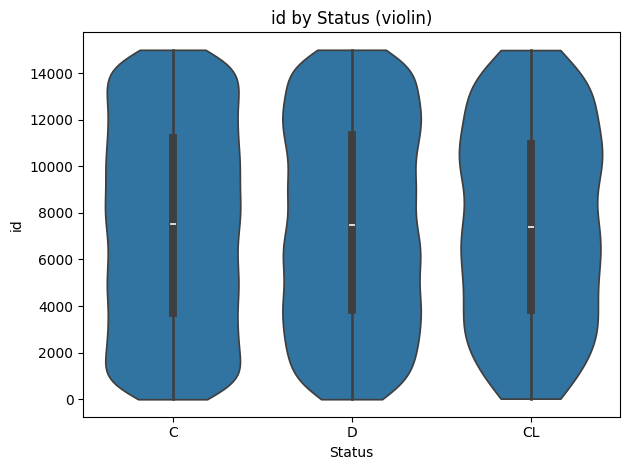

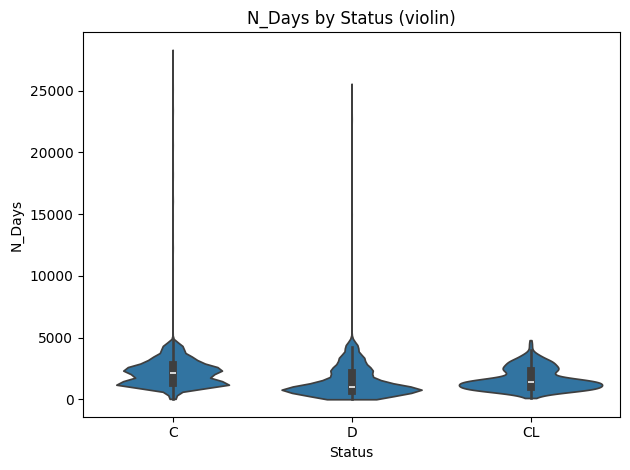

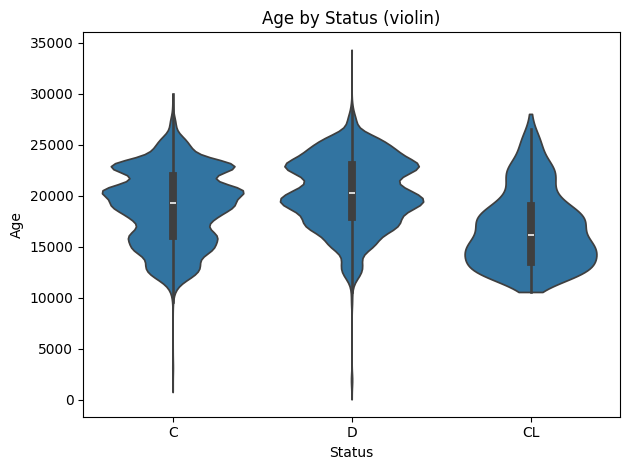

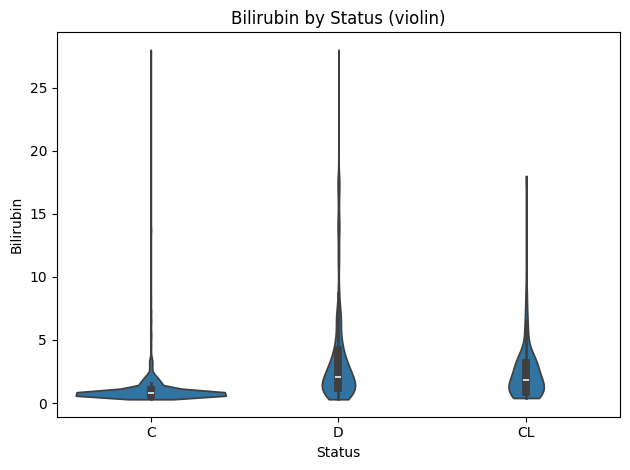

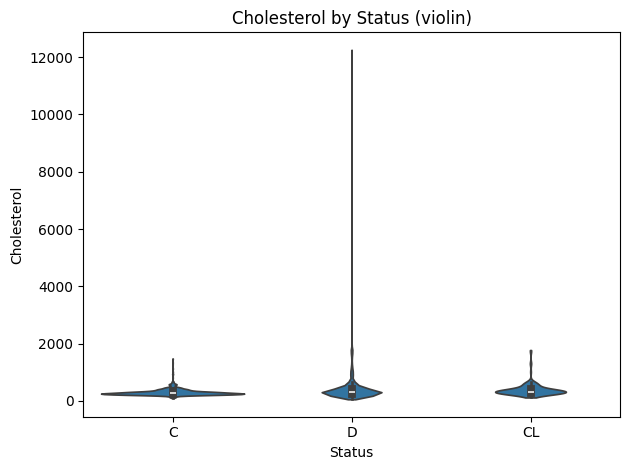

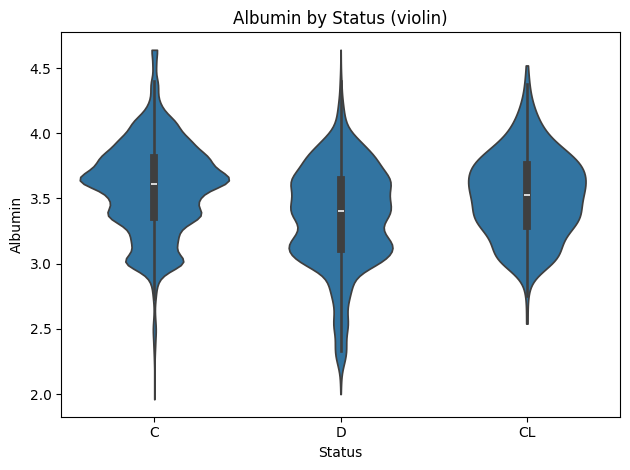

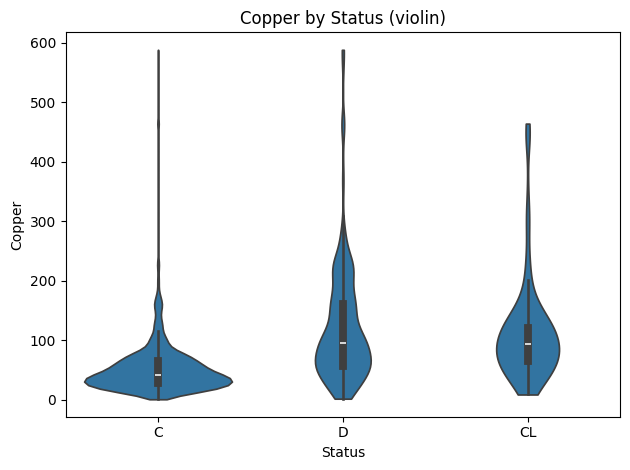

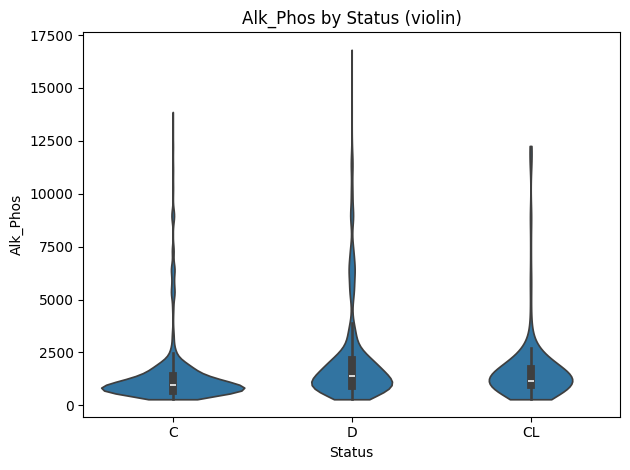

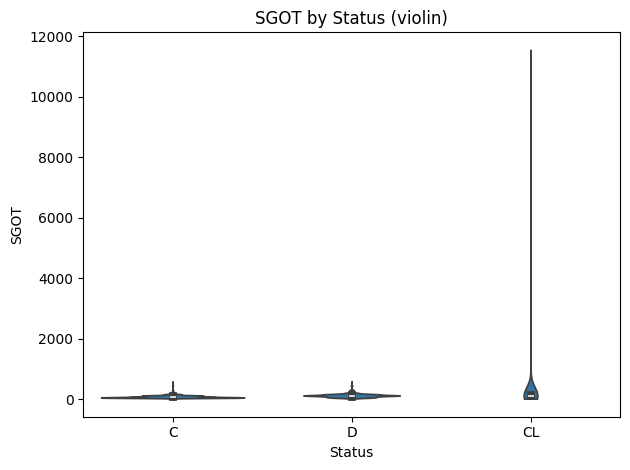

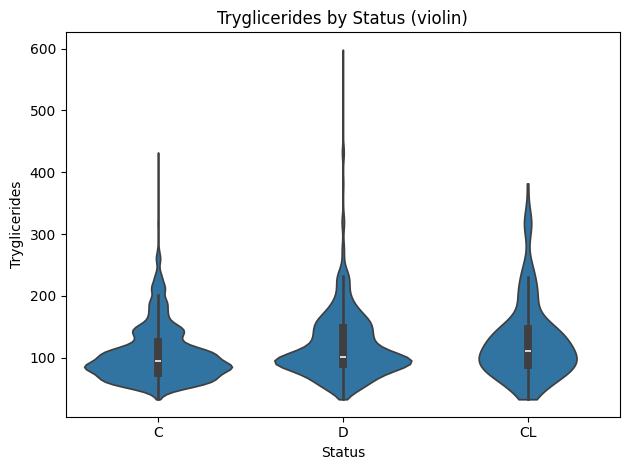

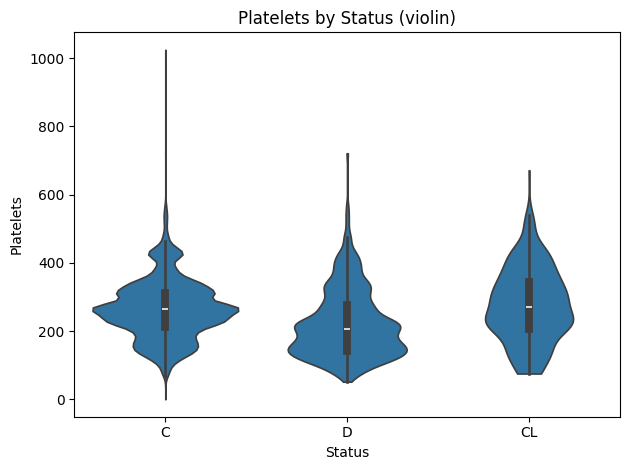

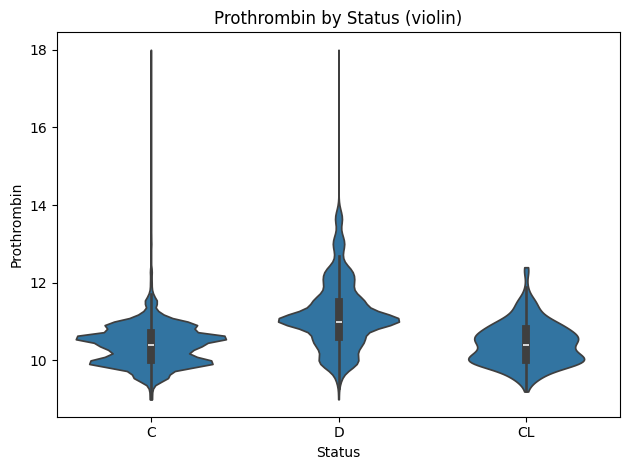

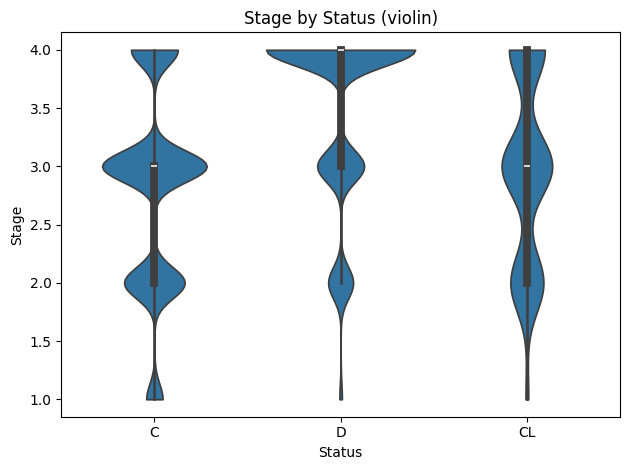

In [15]:
for col in numeric_features:
    plt.figure()
    sns.violinplot(x=target_col, y=col, data=train, cut=0)
    plt.title(f"{col} by {target_col} (violin)")
    plt.tight_layout()
    plt.show()


In [17]:
group_stats = train.groupby(target_col)[numeric_features].agg(["mean", "median"])
group_stats



id               N_Days                   Age           \
               mean  median         mean  median          mean   median   
Status                                                                    
C       7472.713585  7509.5  2202.994700  2149.0  18963.984590  19258.0   
CL      7535.402817  7409.0  1650.887324  1419.0  16821.583099  16112.0   
D       7557.869868  7462.0  1462.648643  1022.0  20274.551492  20296.0   

       Bilirubin        Cholesterol         ...        SGOT          \
            mean median        mean median  ...        mean  median   
Status                                      ...                       
C       1.087554    0.8  301.496241  273.0  ...   93.506448   83.00   
CL      2.600000    1.8  388.672414  325.0  ...  181.876832  122.45   
D       3.601772    2.1  392.691557  302.0  ...  132.634982  130.00   

       Tryglicerides          Platelets        Prothrombin            Stage  \
                mean median        mean median        mean median      mean   
Status                                                                        
C         105.990547   95.0  264.702871  265.0   10.412885   10.4  2.796525   
CL        126.449704  111.0  275.864943  270.0   10.433803   10.4  2.977465   
D         120.603604  102.0  223.263442  206.0   11.165310   11.0  3.533318   

               
       median  
Status         
C         3.0  
CL        3.0  
D         4.0  

[3 rows x 26 columns]


=== Drug vs Status (% by Drug) ===


Status,C,CL,D
Drug,,,
D-penicillamine,69.45,2.68,27.87
Placebo,66.24,2.06,31.70


<Figure size 640x480 with 0 Axes>

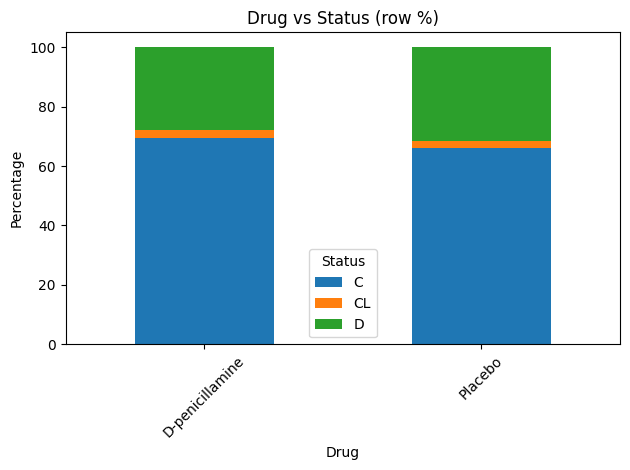


=== Sex vs Status (% by Sex) ===


Status,C,CL,D
Sex,,,
F,68.98,2.30,28.72
M,45.66,3.68,50.66


<Figure size 640x480 with 0 Axes>

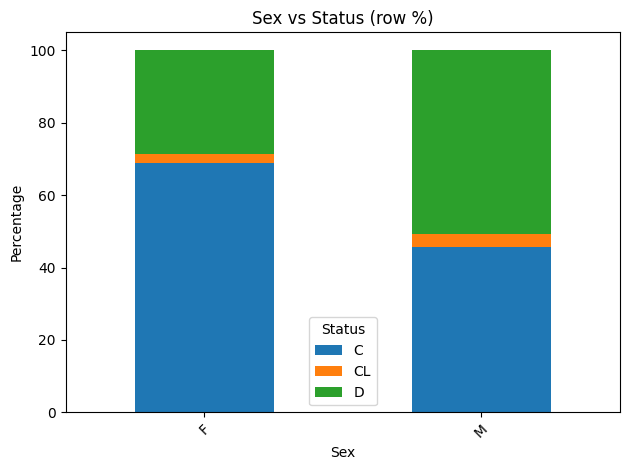


=== Ascites vs Status (% by Ascites) ===


Status,C,CL,D
Ascites,,,
N,70.87,2.5,26.63
Y,4.79,0.0,95.21


<Figure size 640x480 with 0 Axes>

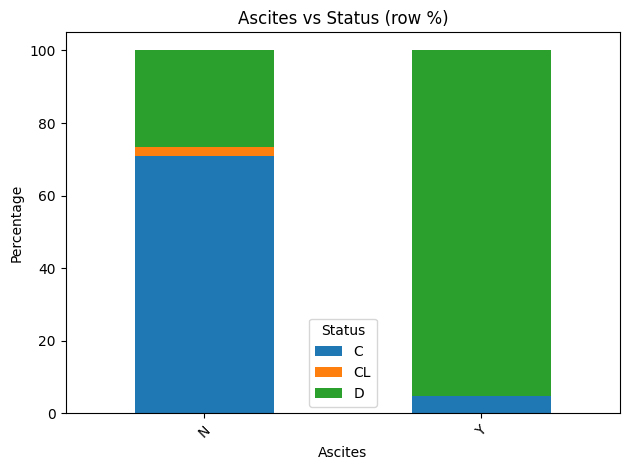


=== Hepatomegaly vs Status (% by Hepatomegaly) ===


Status,C,CL,D
Hepatomegaly,,,
N,85.97,2.10,11.93
Y,46.18,2.74,51.08


<Figure size 640x480 with 0 Axes>

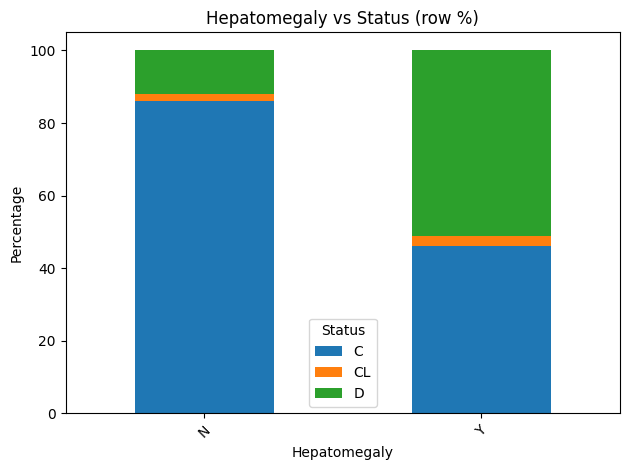


=== Spiders vs Status (% by Spiders) ===


Status,C,CL,D
Spiders,,,
N,77.00,2.35,20.65
Y,34.12,2.52,63.36


<Figure size 640x480 with 0 Axes>

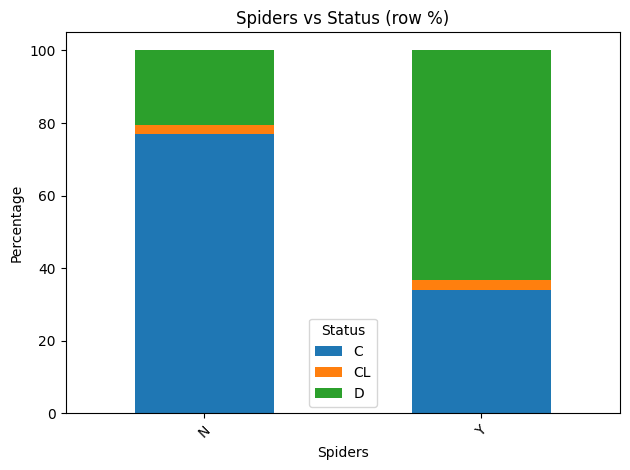


=== Edema vs Status (% by Edema) ===


Status,C,CL,D
Edema,,,
N,71.48,2.40,26.13
S,35.45,2.98,61.58
Y,1.64,0.00,98.36


<Figure size 640x480 with 0 Axes>

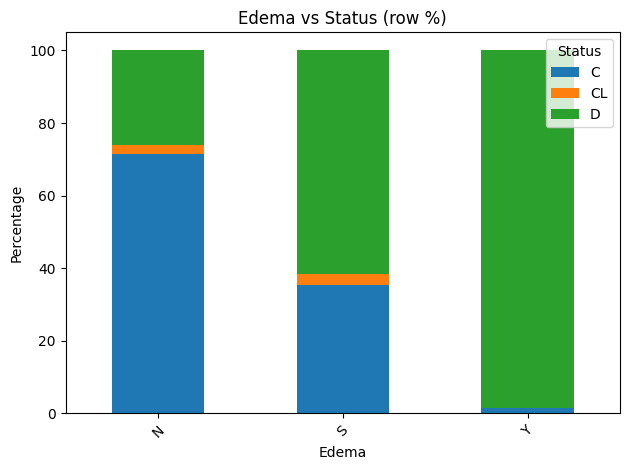

In [18]:
for col in categorical_features:
    ctab = pd.crosstab(train[col], train[target_col], normalize="index") * 100
    print(f"\n=== {col} vs {target_col} (% by {col}) ===")
    display(ctab.round(2))
    
    plt.figure()
    ctab.plot(kind="bar", stacked=True)
    plt.title(f"{col} vs {target_col} (row %)")
    plt.ylabel("Percentage")
    plt.xticks(rotation=45)
    plt.legend(title=target_col)
    plt.tight_layout()
    plt.show()


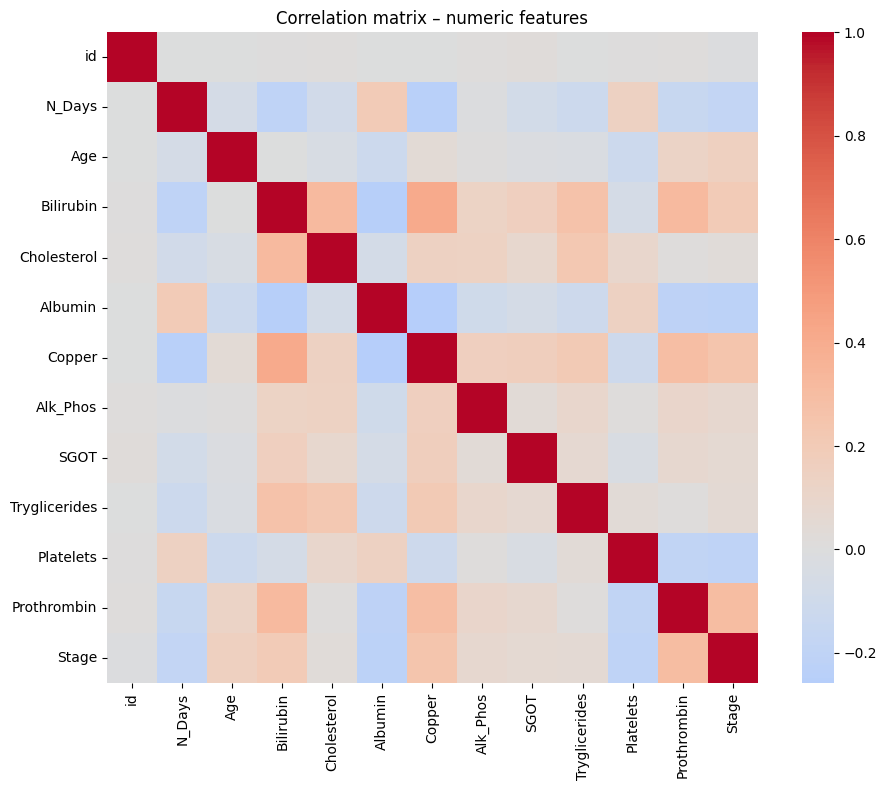

In [20]:
# Correlation matrix
corr = train[numeric_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0, square=True)
plt.title("Correlation matrix – numeric features")
plt.tight_layout()
plt.show()


In [3]:
# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['id', 'N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']
Categorical features: ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']


In [11]:
import os
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
# Adjust to your environment
data_dir = r"C:\liver"

train_path = os.path.join(data_dir, "train.csv")
test_path  = os.path.join(data_dir, "test.csv")

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

print("Train shape:", train.shape)
print("Test shape :", test.shape)
train.head()


Train shape: (15000, 20)
Test shape : (10000, 19)


,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,990.0,NaN,12784.0,F,NaN,NaN,NaN,N,3.0,NaN,3.40,NaN,NaN,NaN,NaN,139.0,9.9,3.0,C
1,1,1367.0,NaN,20819.0,F,NaN,NaN,NaN,S,0.8,NaN,3.76,NaN,NaN,NaN,NaN,80.0,11.1,4.0,C
2,2,1746.0,NaN,19724.0,F,NaN,NaN,NaN,N,1.3,NaN,3.76,NaN,NaN,NaN,NaN,260.0,10.8,2.0,D
3,3,2635.0,NaN,21550.0,F,NaN,NaN,NaN,N,1.3,NaN,3.60,NaN,NaN,NaN,NaN,141.0,10.3,4.0,D
4,4,2716.0,NaN,23011.0,F,NaN,NaN,NaN,N,0.8,NaN,3.15,NaN,NaN,NaN,NaN,371.0,10.2,4.0,C


In [12]:
# lab columns to use for missing count etc.
lab_cols = [
    "Bilirubin", "Cholesterol", "Albumin", "Copper",
    "Alk_Phos", "SGOT", "Tryglicerides",
    "Platelets", "Prothrombin"
]

log_cols = [
    "Bilirubin", "Cholesterol", "Tryglicerides",
    "SGOT", "Alk_Phos"
]

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    # 1) Age in years (Age looks like days in this dataset)
    if "Age" in df.columns:
        df["Age_years"] = df["Age"] / 365.25
    
    # 2) Log1p transforms for skewed lab features
    for col in log_cols:
        if col in df.columns:
            # clip to avoid negative; log1p handles NaN automatically
            df[f"{col}_log1p"] = np.log1p(df[col].clip(lower=0))
    
    # 3) Count of missing lab values per row
    existing_lab_cols = [c for c in lab_cols if c in df.columns]
    df["lab_missing_count"] = df[existing_lab_cols].isna().sum(axis=1)
    
    return df


In [13]:
train_fe = add_features(train)
test_fe  = add_features(test)

print("Train_fe shape:", train_fe.shape)
print("Test_fe shape :", test_fe.shape)
train_fe.head()


Train_fe shape: (15000, 27)
Test_fe shape : (10000, 26)


,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,...,Prothrombin,Stage,Status,Age_years,Bilirubin_log1p,Cholesterol_log1p,Tryglicerides_log1p,SGOT_log1p,Alk_Phos_log1p,lab_missing_count
0,0,990.0,NaN,12784.0,F,NaN,NaN,NaN,N,3.0,...,9.9,3.0,C,35.000684,1.386294,NaN,NaN,NaN,NaN,5
1,1,1367.0,NaN,20819.0,F,NaN,NaN,NaN,S,0.8,...,11.1,4.0,C,56.999316,0.587787,NaN,NaN,NaN,NaN,5
2,2,1746.0,NaN,19724.0,F,NaN,NaN,NaN,N,1.3,...,10.8,2.0,D,54.001369,0.832909,NaN,NaN,NaN,NaN,5
3,3,2635.0,NaN,21550.0,F,NaN,NaN,NaN,N,1.3,...,10.3,4.0,D,59.000684,0.832909,NaN,NaN,NaN,NaN,5
4,4,2716.0,NaN,23011.0,F,NaN,NaN,NaN,N,0.8,...,10.2,4.0,C,63.000684,0.587787,NaN,NaN,NaN,NaN,5


In [14]:
target_col = "Status"

X = train_fe.drop(columns=[target_col])
y = train_fe[target_col]

X_test = test_fe.copy()

print("X shape     :", X.shape)
print("y shape     :", y.shape)
print("X_test shape:", X_test.shape)


X shape     : (15000, 26)
y shape     : (15000,)
X_test shape: (10000, 26)


In [15]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['id', 'N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Age_years', 'Bilirubin_log1p', 'Cholesterol_log1p', 'Tryglicerides_log1p', 'SGOT_log1p', 'Alk_Phos_log1p', 'lab_missing_count']
Categorical features: ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']


In [16]:
numeric_transformer = SimpleImputer(strategy="median")

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

preprocessor


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [17]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=1000,
    n_jobs=-1
)

clf_baseline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", log_reg)
])

clf_baseline.fit(X, y)

# Check predicted probabilities for first 5 rows
proba_sample = clf_baseline.predict_proba(X.iloc[:5])
print("Classes order:", clf_baseline.named_steps["model"].classes_)
print("Sample probabilities:\n", proba_sample)


c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classes order: ['C' 'CL' 'D']
Sample probabilities:
 [[0.42994828 0.04981366 0.52023806]
 [0.55466165 0.00821201 0.43712634]
 [0.78004138 0.01771652 0.20224209]
 [0.68797257 0.00647183 0.30555559]
 [0.88289076 0.0101179  0.10699133]]


In [18]:
import numpy as np
from sklearn.metrics import log_loss

# ترتيب الفئات بشكل ثابت
classes = np.sort(y.unique())
print("Classes:", classes)

# حساب توزيع الفئات في بيانات التدريب
class_freq = y.value_counts(normalize=True).reindex(classes)
print("Class frequencies:\n", class_freq)

# بناء مصفوفة احتمالات ثابتة: كل صف = [P(C), P(CL), P(D)]
proba_const = np.tile(class_freq.values, (len(y), 1))

# حساب log-loss للـ baseline
baseline_loss = log_loss(y, proba_const, labels=classes)
print("Constant baseline log-loss:", baseline_loss)


Classes: ['C' 'CL' 'D']
Class frequencies:
 Status
C     0.679200
CL    0.023667
D     0.297133
Name: proportion, dtype: float64
Constant baseline log-loss: 0.7119354739998986


In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

# تعريف النموذج (بدون multi_class لتجنب التحذير)
log_reg = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    n_jobs=-1
)

# Pipeline كاملة: تجهيز البيانات + الموديل
from sklearn.pipeline import Pipeline

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", log_reg)
])

# إعداد K-Fold
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# مصفوفة OOF probabilities
oof_proba = np.zeros((len(X), len(classes)))

fold_losses = []

for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y), start=1):
    X_tr, X_val = X.iloc[train_idx], X.iloc[valid_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[valid_idx]
    
    # تدريب على بيانات الـ fold
    clf.fit(X_tr, y_tr)
    
    # احتمالات على جزء التحقق
    proba_val = clf.predict_proba(X_val)  # ترتيب الأعمدة = clf.classes_
    
    # نضمن أن ترتيب الأعمدة متوافق مع "classes"
    model_classes = clf.named_steps["model"].classes_
    # إعادة ترتيب الأعمدة لو لزم
    reorder_idx = [np.where(model_classes == c)[0][0] for c in classes]
    proba_val_ordered = proba_val[:, reorder_idx]
    
    # حفظ في OOF
    oof_proba[valid_idx] = proba_val_ordered
    
    # log-loss لهذا الـ fold
    fold_loss = log_loss(y_val, proba_val_ordered, labels=classes)
    fold_losses.append(fold_loss)
    print(f"Fold {fold} log-loss: {fold_loss:.5f}")

# log-loss الكلي على OOF
overall_loss = log_loss(y, oof_proba, labels=classes)
print("\nFold losses:", [round(fl, 5) for fl in fold_losses])
print("Mean fold loss:", np.mean(fold_losses))
print("OOF overall log-loss:", overall_loss)


Fold 1 log-loss: 0.59098
Fold 2 log-loss: 0.55508
Fold 3 log-loss: 0.57868
Fold 4 log-loss: 0.55418
Fold 5 log-loss: 0.53808

Fold losses: [0.59098, 0.55508, 0.57868, 0.55418, 0.53808]
Mean fold loss: 0.5634007062273867
OOF overall log-loss: 0.5634007062273865


In [20]:
# تدريب نهائي على كل بيانات التدريب
clf.fit(X, y)

# التأكد من ترتيب الفئات
final_model_classes = clf.named_steps["model"].classes_
print("Final model classes:", final_model_classes)


Final model classes: ['C' 'CL' 'D']


In [21]:
# توقع الاحتمالات على test
test_proba_raw = clf.predict_proba(X_test)

# إعادة ترتيب الأعمدة حسب ترتيب classes = ['C','CL','D']
reorder_idx_test = [np.where(final_model_classes == c)[0][0] for c in classes]
test_proba = test_proba_raw[:, reorder_idx_test]

# بناء DataFrame للاحتمالات
proba_df = pd.DataFrame(
    test_proba,
    columns=[f"Status_{c}" for c in classes]  # -> Status_C, Status_CL, Status_D
)

proba_df.head()


,Status_C,Status_CL,Status_D
0,0.772391,0.036576,0.191034
1,0.861288,0.008865,0.129847
2,0.870942,0.008777,0.120281
3,0.792021,0.071411,0.136568
4,0.913362,0.006222,0.080416


In [22]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# لو مش موجودة، عرّف X, y, X_test من train_fe / test_fe
# target_col = "Status"
# X = train_fe.drop(columns=[target_col])
# y = train_fe[target_col]
# X_test = test_fe.copy()

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)

numeric_transformer_tree = SimpleImputer(strategy="median")

categorical_transformer_tree = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor_tree = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_tree, numeric_features),
        ("cat", categorical_transformer_tree, categorical_features),
    ]
)

preprocessor_tree


Numeric: ['id', 'N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Age_years', 'Bilirubin_log1p', 'Cholesterol_log1p', 'Tryglicerides_log1p', 'SGOT_log1p', 'Alk_Phos_log1p', 'lab_missing_count']
Categorical: ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [23]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

# ترتيب الفئات
classes = np.sort(y.unique())
print("Classes:", classes)

# تعريف الموديل مع بارامترات مبدئية معقولة
hgb_params = dict(
    loss="log_loss",          # Multi-class log-loss
    learning_rate=0.05,
    max_depth=None,           # يضبط تلقائيًا مع num_leaves
    max_leaf_nodes=31,
    min_samples_leaf=20,
    max_iter=500,
    l2_regularization=1.0,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)

hgb = HistGradientBoostingClassifier(**hgb_params)

clf_hgb = Pipeline(steps=[
    ("preprocessor", preprocessor_tree),
    ("model", hgb)
])

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

oof_proba_hgb = np.zeros((len(X), len(classes)))
fold_losses_hgb = []

for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y), start=1):
    X_tr, X_val = X.iloc[train_idx], X.iloc[valid_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[valid_idx]
    
    clf_hgb.fit(X_tr, y_tr)
    
    proba_val = clf_hgb.predict_proba(X_val)  # ترتيب الأعمدة = clf_hgb.named_steps["model"].classes_
    
    model_classes = clf_hgb.named_steps["model"].classes_
    reorder_idx = [np.where(model_classes == c)[0][0] for c in classes]
    proba_val_ordered = proba_val[:, reorder_idx]
    
    oof_proba_hgb[valid_idx] = proba_val_ordered
    
    fold_loss = log_loss(y_val, proba_val_ordered, labels=classes)
    fold_losses_hgb.append(fold_loss)
    print(f"Fold {fold} HGB log-loss: {fold_loss:.5f}")

overall_loss_hgb = log_loss(y, oof_proba_hgb, labels=classes)
print("\nHGB fold losses:", [round(fl, 5) for fl in fold_losses_hgb])
print("HGB mean fold loss:", np.mean(fold_losses_hgb))
print("HGB OOF overall log-loss:", overall_loss_hgb)


Classes: ['C' 'CL' 'D']
Fold 1 HGB log-loss: 0.38567
Fold 2 HGB log-loss: 0.37696
Fold 3 HGB log-loss: 0.38887
Fold 4 HGB log-loss: 0.40082
Fold 5 HGB log-loss: 0.37762

HGB fold losses: [0.38567, 0.37696, 0.38887, 0.40082, 0.37762]
HGB mean fold loss: 0.3859885304646513
HGB OOF overall log-loss: 0.3859885304646513


In [24]:
# تدريب نهائي على كل بيانات التدريب
clf_hgb.fit(X, y)

final_hgb_classes = clf_hgb.named_steps["model"].classes_
print("Final HGB model classes:", final_hgb_classes)


Final HGB model classes: ['C' 'CL' 'D']


In [25]:
test_proba_raw_hgb = clf_hgb.predict_proba(X_test)

# ترتيب الأعمدة حسب classes = ['C','CL','D']
reorder_idx_test_hgb = [np.where(final_hgb_classes == c)[0][0] for c in classes]
test_proba_hgb = test_proba_raw_hgb[:, reorder_idx_test_hgb]

proba_df_hgb = pd.DataFrame(
    test_proba_hgb,
    columns=[f"Status_{c}" for c in classes]  # Status_C, Status_CL, Status_D
)

proba_df_hgb.head()


,Status_C,Status_CL,Status_D
0,0.960419,0.016311,0.023271
1,0.906812,0.013311,0.079877
2,0.991360,0.001000,0.007639
3,0.974730,0.007884,0.017386
4,0.980144,0.002414,0.017442


In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from catboost import CatBoostClassifier

target_col = "Status"

# Use feature-engineered data from previous phases
X_cb = train_fe.drop(columns=[target_col]).copy()
y_cb = train_fe[target_col].copy()
X_test_cb = test_fe.copy()

print("X_cb shape:", X_cb.shape)
print("y_cb shape:", y_cb.shape)
print("X_test_cb shape:", X_test_cb.shape)

# Classes
classes = np.sort(y_cb.unique())
print("Classes:", classes)

# Identify categorical columns (object or category)
cat_cols = X_cb.select_dtypes(include=["object", "category"]).columns.tolist()
print("Categorical columns:", cat_cols)

# Convert categorical columns to string and fill missing with a label
for c in cat_cols:
    X_cb[c] = X_cb[c].astype("string").fillna("missing")
    X_test_cb[c] = X_test_cb[c].astype("string").fillna("missing")

# Now get categorical feature indices for CatBoost
cat_features = [X_cb.columns.get_loc(c) for c in cat_cols]
print("Categorical feature indices:", cat_features)


X_cb shape: (15000, 26)
y_cb shape: (15000,)
X_test_cb shape: (10000, 26)
Classes: ['C' 'CL' 'D']
Categorical columns: ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
Categorical feature indices: [2, 4, 5, 6, 7, 8]


In [34]:
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

oof_proba_cat = np.zeros((len(X_cb), len(classes)))
fold_losses_cat = []

for fold, (train_idx, valid_idx) in enumerate(cv.split(X_cb, y_cb), start=1):
    X_tr, X_val = X_cb.iloc[train_idx], X_cb.iloc[valid_idx]
    y_tr, y_val = y_cb.iloc[train_idx], y_cb.iloc[valid_idx]
    
    model_cat = CatBoostClassifier(
        loss_function="MultiClass",
        eval_metric="MultiClass",
        learning_rate=0.05,
        depth=6,
        l2_leaf_reg=3.0,
        iterations=2000,
        random_seed=42,
        od_type="Iter",   # early stopping
        od_wait=100,
        verbose=False
    )
    
    model_cat.fit(
        X_tr, y_tr,
        cat_features=cat_features,
        eval_set=(X_val, y_val),
        use_best_model=True
    )
    
    proba_val = model_cat.predict_proba(X_val)  # (n_val, 3)
    
    # Ensure probabilities follow [C, CL, D]
    model_classes = model_cat.classes_
    reorder_idx = [np.where(model_classes == c)[0][0] for c in classes]
    proba_val_ordered = proba_val[:, reorder_idx]
    
    oof_proba_cat[valid_idx] = proba_val_ordered
    
    fold_loss = log_loss(y_val, proba_val_ordered, labels=classes)
    fold_losses_cat.append(fold_loss)
    print(f"Fold {fold} CatBoost log-loss: {fold_loss:.5f}")

overall_loss_cat = log_loss(y_cb, oof_proba_cat, labels=classes)
print("\nCatBoost fold losses:", [round(fl, 5) for fl in fold_losses_cat])
print("CatBoost mean fold loss:", np.mean(fold_losses_cat))
print("CatBoost OOF overall log-loss:", overall_loss_cat)


Fold 1 CatBoost log-loss: 0.37792
Fold 2 CatBoost log-loss: 0.37659
Fold 3 CatBoost log-loss: 0.37668
Fold 4 CatBoost log-loss: 0.39330
Fold 5 CatBoost log-loss: 0.37517

CatBoost fold losses: [0.37792, 0.37659, 0.37668, 0.3933, 0.37517]
CatBoost mean fold loss: 0.3799318981604082
CatBoost OOF overall log-loss: 0.37993189816040807


In [35]:
model_cat_full = CatBoostClassifier(
    loss_function="MultiClass",
    eval_metric="MultiClass",
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3.0,
    iterations=2000,
    random_seed=42,
    od_type=None,
    verbose=False
)

model_cat_full.fit(
    X_cb, y_cb,
    cat_features=cat_features
)

final_cat_classes = model_cat_full.classes_
print("Final CatBoost classes:", final_cat_classes)


Final CatBoost classes: ['C' 'CL' 'D']


In [36]:
test_proba_raw_cat = model_cat_full.predict_proba(X_test_cb)

reorder_idx_test_cat = [np.where(final_cat_classes == c)[0][0] for c in classes]
test_proba_cat = test_proba_raw_cat[:, reorder_idx_test_cat]

proba_df_cat = pd.DataFrame(
    test_proba_cat,
    columns=[f"Status_{c}" for c in classes]  # Status_C, Status_CL, Status_D
)

assert "id" in X_test_cb.columns, "Column 'id' not found in test data!"

submission_cat = pd.DataFrame({
    "id": X_test_cb["id"].values
})
submission_cat = pd.concat([submission_cat, proba_df_cat], axis=1)

out_path_cat = r"C:\liver\submission_catboost_baseline.csv"
submission_cat.to_csv(out_path_cat, index=False)

print("CatBoost submission saved to:", out_path_cat)
submission_cat.head()


CatBoost submission saved to: C:\liver\submission_catboost_baseline.csv


,id,Status_C,Status_CL,Status_D
0,15000,0.958967,0.022784,0.018249
1,15001,0.933644,0.013097,0.053259
2,15002,0.997464,0.000304,0.002232
3,15003,0.989985,0.006095,0.003920
4,15004,0.994490,0.000434,0.005075


In [37]:
import numpy as np
import pandas as pd

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

target_col = "Status"

X_lgb = train_fe.drop(columns=[target_col]).copy()
y_lgb = train_fe[target_col].copy()
X_test_lgb = test_fe.copy()

print("X_lgb shape:", X_lgb.shape)
print("y_lgb shape:", y_lgb.shape)
print("X_test_lgb shape:", X_test_lgb.shape)

# Classes (C, CL, D)
classes = np.sort(y_lgb.unique())
print("Classes:", classes)

# Map classes to integer indices for LightGBM
class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}
y_lgb_idx = y_lgb.map(class_to_idx)

# Identify categorical columns
cat_cols = X_lgb.select_dtypes(include=["object", "category"]).columns.tolist()
print("Categorical columns:", cat_cols)

# Ensure they are category dtype (LightGBM can use this)
for c in cat_cols:
    X_lgb[c] = X_lgb[c].astype("category")
    X_test_lgb[c] = X_test_lgb[c].astype("category")


X_lgb shape: (15000, 26)
y_lgb shape: (15000,)
X_test_lgb shape: (10000, 26)
Classes: ['C' 'CL' 'D']
Categorical columns: ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']


In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from lightgbm import LGBMClassifier

target_col = "Status"

X_lgb = train_fe.drop(columns=[target_col]).copy()
y_lgb = train_fe[target_col].copy()
X_test_lgb = test_fe.copy()

print("X_lgb shape:", X_lgb.shape)
print("y_lgb shape:", y_lgb.shape)
print("X_test_lgb shape:", X_test_lgb.shape)

# classes: ['C','CL','D']
classes = np.sort(y_lgb.unique())
print("Classes:", classes)

# map classes -> indices 0,1,2
class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}
y_lgb_idx = y_lgb.map(class_to_idx).values

# categorical columns
cat_cols = X_lgb.select_dtypes(include=["object", "category"]).columns.tolist()
print("Categorical columns:", cat_cols)

# ensure categorical dtype for LightGBM
for c in cat_cols:
    X_lgb[c] = X_lgb[c].astype("category")
    X_test_lgb[c] = X_test_lgb[c].astype("category")


X_lgb shape: (15000, 26)
y_lgb shape: (15000,)
X_test_lgb shape: (10000, 26)
Classes: ['C' 'CL' 'D']
Categorical columns: ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']


In [41]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from lightgbm import LGBMClassifier
import numpy as np

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

oof_proba_lgb = np.zeros((len(X_lgb), len(classes)))
fold_losses_lgb = []

for fold, (train_idx, valid_idx) in enumerate(cv.split(X_lgb, y_lgb_idx), start=1):
    X_tr, X_val = X_lgb.iloc[train_idx], X_lgb.iloc[valid_idx]
    y_tr_idx = y_lgb_idx[train_idx]
    y_val_idx = y_lgb_idx[valid_idx]
    
    model_lgb = LGBMClassifier(
        objective="multiclass",
        num_class=len(classes),
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=-1,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42
    )
    
    # SIMPLE FIT: no verbose, no eval_set, no eval_metric
    model_lgb.fit(X_tr, y_tr_idx)
    
    # Probabilities for validation fold
    proba_val = model_lgb.predict_proba(X_val)  # shape (n_val, 3), order [0,1,2]
    
    # Store OOF probabilities
    oof_proba_lgb[valid_idx] = proba_val
    
    # log-loss using integer labels 0,1,2
    fold_loss = log_loss(y_val_idx, proba_val, labels=[0, 1, 2])
    fold_losses_lgb.append(fold_loss)
    print(f"Fold {fold} LightGBM log-loss: {fold_loss:.5f}")

overall_loss_lgb = log_loss(y_lgb_idx, oof_proba_lgb, labels=[0, 1, 2])
print("\nLightGBM fold losses:", [round(fl, 5) for fl in fold_losses_lgb])
print("LightGBM mean fold loss:", np.mean(fold_losses_lgb))
print("LightGBM OOF overall log-loss:", overall_loss_lgb)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3316
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 26
[LightGBM] [Info] Start training from score -0.386889
[LightGBM] [Info] Start training from score -3.743688
[LightGBM] [Info] Start training from score -1.213462
Fold 1 LightGBM log-loss: 0.44034
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3324
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 26
[LightGBM] [Info] Start training from score -0.386889
[LightGBM] [Info] Start training from score 

In [42]:
model_lgb_full = LGBMClassifier(
    objective="multiclass",
    num_class=len(classes),
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42
)

model_lgb_full.fit(X_lgb, y_lgb_idx)

# Predict on test
test_proba_lgb = model_lgb_full.predict_proba(X_test_lgb)  # shape (n_test, 3)

# Build DataFrame with correct columns
proba_df_lgb = pd.DataFrame(
    test_proba_lgb,
    columns=[f"Status_{c}" for c in classes]   # classes = ['C','CL','D']
)

assert "id" in X_test_lgb.columns, "Column 'id' not found in test data!"

submission_lgb = pd.DataFrame({
    "id": X_test_lgb["id"].values
})
submission_lgb = pd.concat([submission_lgb, proba_df_lgb], axis=1)

out_path_lgb = r"C:\liver\submission_lightgbm_baseline.csv"
submission_lgb.to_csv(out_path_lgb, index=False)

print("LightGBM submission saved to:", out_path_lgb)
submission_lgb.head()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3336
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 26
[LightGBM] [Info] Start training from score -0.386840
[LightGBM] [Info] Start training from score -3.743688
[LightGBM] [Info] Start training from score -1.213574
LightGBM submission saved to: C:\liver\submission_lightgbm_baseline.csv


,id,Status_C,Status_CL,Status_D
0,15000,0.988359,0.002164,0.009477
1,15001,0.888109,0.007997,0.103894
2,15002,0.999732,0.000003,0.000265
3,15003,0.998255,0.000735,0.001010
4,15004,0.995972,0.000028,0.004000


In [43]:
import numpy as np
from sklearn.metrics import log_loss

# sanity check
print(oof_proba_cat.shape, oof_proba_lgb.shape)
print("Classes:", classes)

weights = np.arange(0.0, 1.01, 0.05)

best_loss_2 = float("inf")
best_w_cat_2 = None
best_w_lgb_2 = None

for w_cat in weights:
    w_lgb = 1.0 - w_cat
    
    blend_oof = w_cat * oof_proba_cat + w_lgb * oof_proba_lgb
    
    loss = log_loss(y_cb, blend_oof, labels=classes)
    if loss < best_loss_2:
        best_loss_2 = loss
        best_w_cat_2 = w_cat
        best_w_lgb_2 = w_lgb

print("Best 2-model blend (CatBoost + LightGBM):")
print("  w_cat =", best_w_cat_2, "  w_lgb =", best_w_lgb_2)
print("  OOF log-loss =", best_loss_2)


(15000, 3) (15000, 3)
Classes: ['C' 'CL' 'D']
Best 2-model blend (CatBoost + LightGBM):
  w_cat = 0.75   w_lgb = 0.25
  OOF log-loss = 0.3771154075021665


In [46]:
import pandas as pd

path_cat = r"C:\liver\submission_catboost_baseline.csv"
path_lgb = r"C:\liver\submission_lightgbm_baseline.csv"

sub_cat = pd.read_csv(path_cat)
sub_lgb = pd.read_csv(path_lgb)

# Ensure same ordering of rows
assert (sub_cat["id"].values == sub_lgb["id"].values).all()

cols = ["Status_C", "Status_CL", "Status_D"]

w_cat = best_w_cat_2
w_lgb = best_w_lgb_2

blend_test = (
    w_cat * sub_cat[cols].values +
    w_lgb * sub_lgb[cols].values
)

sub_blend = pd.DataFrame({
    "id": sub_cat["id"].values
})
for i, c in enumerate(cols):
    sub_blend[c] = blend_test[:, i]

out_path_blend = r"C:\liver\submission_blend_cat_lgb.csv"
sub_blend.to_csv(out_path_blend, index=False)

print("Blended (CatBoost + LightGBM) submission saved to:", out_path_blend)
sub_blend.head()


Blended (CatBoost + LightGBM) submission saved to: C:\liver\submission_blend_cat_lgb.csv


,id,Status_C,Status_CL,Status_D
0,15000,0.966315,0.017629,0.016056
1,15001,0.922260,0.011822,0.065918
2,15002,0.998031,0.000229,0.001741
3,15003,0.992053,0.004755,0.003192
4,15004,0.994861,0.000333,0.004806


In [47]:
import numpy as np
from sklearn.metrics import log_loss

# final weights
w_log = 0.0
w_hgb = 0.2
w_cat = 0.6
w_lgb = 0.2

# blended OOF probabilities
oof_blend = (
    w_log * oof_proba +
    w_hgb * oof_proba_hgb +
    w_cat * oof_proba_cat +
    w_lgb * oof_proba_lgb
)

# overall log-loss (should be ~0.3764)
overall_blend_loss = log_loss(y_cb, oof_blend, labels=classes)
print("Overall blended OOF log-loss:", overall_blend_loss)

# per-class log-loss
for c in classes:
    mask = (y_cb == c)
    class_idx = np.where(classes == c)[0][0]
    probs_true_class = oof_blend[mask, class_idx]
    # numerical safety
    probs_true_class = np.clip(probs_true_class, 1e-15, 1 - 1e-15)
    loss_c = -np.mean(np.log(probs_true_class))
    print(f"Log-loss for class {c}: {loss_c:.5f}")


Overall blended OOF log-loss: 0.37640549645051063
Log-loss for class C: 0.19506
Log-loss for class CL: 2.88593
Log-loss for class D: 0.59104


In [48]:
import numpy as np
from sklearn.metrics import log_loss

# final weights
w_log = 0.0
w_hgb = 0.2
w_cat = 0.6
w_lgb = 0.2

# blended OOF probabilities
oof_blend = (
    w_log * oof_proba +
    w_hgb * oof_proba_hgb +
    w_cat * oof_proba_cat +
    w_lgb * oof_proba_lgb
)

# overall log-loss (should be ~0.3764)
overall_blend_loss = log_loss(y_cb, oof_blend, labels=classes)
print("Overall blended OOF log-loss:", overall_blend_loss)

# per-class log-loss
for c in classes:
    mask = (y_cb == c)
    class_idx = np.where(classes == c)[0][0]
    probs_true_class = oof_blend[mask, class_idx]
    # numerical safety
    probs_true_class = np.clip(probs_true_class, 1e-15, 1 - 1e-15)
    loss_c = -np.mean(np.log(probs_true_class))
    print(f"Log-loss for class {c}: {loss_c:.5f}")


Overall blended OOF log-loss: 0.37640549645051063
Log-loss for class C: 0.19506
Log-loss for class CL: 2.88593
Log-loss for class D: 0.59104


In [49]:
from sklearn.metrics import confusion_matrix, classification_report

# convert true labels to indices 0,1,2
y_true_idx = np.array([class_to_idx[label] for label in y_cb])
y_pred_idx = oof_blend.argmax(axis=1)

cm = confusion_matrix(y_true_idx, y_pred_idx, labels=[0,1,2])
print("Confusion matrix (rows=true, cols=pred):")
print(cm)

print("\nClassification report (on argmax of probs):")
print(classification_report(y_true_idx, y_pred_idx, target_names=classes))


Confusion matrix (rows=true, cols=pred):
[[9549   11  628]
 [ 230   27   98]
 [1201    7 3249]]

Classification report (on argmax of probs):
              precision    recall  f1-score   support

           C       0.87      0.94      0.90     10188
          CL       0.60      0.08      0.14       355
           D       0.82      0.73      0.77      4457

    accuracy                           0.85     15000
   macro avg       0.76      0.58      0.60     15000
weighted avg       0.85      0.85      0.84     15000



In [50]:
# negative log-likelihood per row
row_indices = np.arange(len(y_cb))
true_class_idx = np.array([class_to_idx[label] for label in y_cb])

row_probs = oof_blend[row_indices, true_class_idx]
row_probs = np.clip(row_probs, 1e-15, 1 - 1e-15)
neg_log_likelihood = -np.log(row_probs)

# indices of the 20 hardest rows
worst_idx = np.argsort(-neg_log_likelihood)[:20]

print("Indices of 20 hardest rows:", worst_idx)

# inspect their features from original train_fe or train
train_inspect = train_fe.copy()
train_inspect[target_col] = y_cb
train_inspect.loc[worst_idx, ["id", "Status", "N_Days", "Age", "Stage", "Bilirubin", "Albumin", "Prothrombin"]]


Indices of 20 hardest rows: [ 2479 14495  5486  9931  2829  3177  1951 14069  9266   656 14788 14385
   647  2183  3496  6503  3283  7347  4806 14987]


,id,Status,N_Days,Age,Stage,Bilirubin,Albumin,Prothrombin
2479,2479,CL,1783.0,17525.0,3.0,0.6,4.08,10.6
14495,14495,CL,1301.0,13344.0,2.0,0.6,3.67,11.4
5486,5486,CL,625.0,17532.0,3.0,8.1,2.84,11.2
9931,9931,CL,1462.0,23011.0,3.0,0.7,3.40,10.6
2829,2829,CL,3021.0,23011.0,4.0,0.6,3.81,11.0
3177,3177,CL,930.0,22347.0,2.0,0.4,3.58,10.2
1951,1951,CL,732.0,22280.0,4.0,1.3,3.77,11.8
14069,14069,CL,3458.0,20454.0,2.0,0.6,4.04,11.4
9266,9266,CL,877.0,22336.0,2.0,0.6,3.79,10.2
656,656,CL,2580.0,25568.0,4.0,0.6,3.65,10.1


In [51]:
print(y_cb.value_counts())
print(y_cb.value_counts(normalize=True))


Status
C     10188
D      4457
CL      355
Name: count, dtype: int64
Status
C     0.679200
D     0.297133
CL    0.023667
Name: proportion, dtype: float64
